In [2]:
import os
import sys
import warnings
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import wandb

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from ppm.wandb_utils import fetch_experiments

warnings.filterwarnings("ignore")

os.environ.setdefault("ENTITY", "privajet-university-of-mannheim")
entity = os.environ["ENTITY"]
os.environ["WANDB_MODE"] = "offline"

print("CWD:", os.getcwd())
print("project_root in sys.path:", project_root in sys.path)
print("ENTITY:", entity)
print("WANDB_MODE:", os.environ.get("WANDB_MODE"))

CWD: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results
project_root in sys.path: True
ENTITY: privajet-university-of-mannheim
WANDB_MODE: offline


In [3]:
output_dir_csv = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv"
output_dir_plots = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots"
os.makedirs(output_dir_csv, exist_ok=True)
os.makedirs(output_dir_plots, exist_ok=True)

In [4]:
# Display all lines pandas
pd.set_option("display.max_rows", None)

mpl.rcParams.update({
    "figure.figsize": (6, 4),          
    "font.size": 10,                   
    "axes.labelsize": 10,              
    "axes.titlesize": 10,              
    "legend.fontsize": 9,              
    "xtick.labelsize": 9,              
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,            
    "lines.markersize": 5,             
    "axes.grid": True,                 
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "legend.frameon": False,           
    "pdf.fonttype": 42,                
    "ps.fonttype": 42,
    "savefig.bbox": "tight",           
    "savefig.dpi": 300,                
})

colors = [
    "#9467bd",
    "#2ca02c",
    "#bcbd22",
    "#7f7f7f",
    "#e377c2",
    "#8c564b",
    "#d62728",
    "#17becf",
    "#1f77b4",
    "#ff7f0e",
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)  

In [5]:
properties = pd.read_csv(
    "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/log_properties.csv"
)
properties

,Log,# cases,# evt.,# act.,Trace length
0,BPI20PrepaidTravelCosts,2099,18246,29,8.6927±2.3
1,BPI20RequestForPayment,6886,36796,19,5.3436±1.5
2,BPI20TravelPermitData,7065,86581,51,12.2549±5.6
3,BPI12,13087,262200,24,20.0351±19.9
4,BPI17,31509,1202267,26,38.1563±16.7


In [6]:
# from ppm.models import NextEventPredictor
# import torch 

# use_cuda = torch.cuda.is_available()
# device = "cuda" if use_cuda else "cpu"
# print("Using device:", device)

# rnn_example = NextEventPredictor(
#     embedding_size=32,
#     categorical_cols=["activity"],
#     numerical_cols=["accumulated_time"],
#     categorical_sizes={"activity": 20},
#     categorical_targets=["activity"],
#     numerical_targets=["remaining_time"],
#     backbone_name="rnn",
#     backbone_hidden_size=64,
#     backbone_n_layers=2,
#     padding_idx=0,
#     strategy="sum",
#     backbone_pretrained=False,
#     backbone_finetuning=None,
#     backbone_type="lstm",
#     device=device,
# )
# pprint(rnn_example)

In [7]:
def _to_int_or_none(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    try:
        return int(x)
    except Exception:
        return None

def map_setting(row):
    ft = row.get("fine_tuning")
    k_raw = row.get("few_shot_k", None)
    fl    = row.get("freeze_layers", None)
    ep_raw = row.get("epochs", None)

    k  = _to_int_or_none(k_raw)
    ep = _to_int_or_none(ep_raw)

    # LoRA Few-Shot
    if ft == "lora" and k == 8:
        return "FewShot-LoRA"

    # LoRA Full
    if ft == "lora" and k is None:
        return "LoRA"

    # Zero-Shot (epochs = 0)
    if ft == "freeze" and ep == 0:
        return "ZeroShot"

    # Freezing Few-Shot
    if ft == "freeze" and k == 8:
        return "FewShot-Freezing"

    # Freezing standard (keine freeze_layers angegeben)
    if ft == "freeze" and fl in (None, "", [], ()):
        return "Freezing"

    # Freezing layer configs (z.B. -1, -2 / 0, 1)
    if ft == "freeze" and fl is not None:
        if isinstance(fl, (list, tuple)):
            fl_clean = [_to_int_or_none(x) for x in fl]
        else:
            tokens = str(fl).replace("[", "").replace("]", "").replace(",", " ").split()
            fl_clean = [_to_int_or_none(x) for x in tokens]
        fl_clean = [x for x in fl_clean if x is not None]
        return f"Freezing-{fl_clean}"

    return "Other"

In [8]:
pkl_path = os.path.join(output_dir_csv, "global_results.pkl")

BACKBONE_PROJECTS = {
    "majority":         "llm-peft-ppm_majority_baseline",
    "rnn":              "llm-peft-ppm_rnn",
    "transformer":      "llm-peft-ppm_transformer_baseline",
    "tabpfn":           "llm-peft-ppm_tabpfn_baseline",
    "saprpt":           "llm-peft-ppm_saprpt_baseline",
    "gpt2":             "llm-peft-ppm_gpt2",
    "gptneo-1b3":       "llm-peft-ppm_gpt-neo-1.3B",
    "qwen25-05b":       "llm-peft-ppm_qwen25-05b",
    "llama32-1b":       "llm-peft-ppm_llama32-1b",
    "gemma-2-2b":       "llm-peft-ppm_gemma-2-2b",
}

def build_global_results():
    all_results = []
    for backbone, project_name in BACKBONE_PROJECTS.items():
        df_tmp = fetch_experiments(project=project_name, entity=entity, include_metrics=True)
        df_tmp["backbone"] = backbone
        df_tmp["project"] = project_name
        all_results.append(df_tmp)

    gr = pd.concat(all_results, ignore_index=True)

    safe_cols = [
        "id", "log", "backbone", "project", "fine_tuning",
        "total_params", "trainable_params", "seed", "_runtime", "_timestamp",
        "categorical_features", "categorical_targets",
        "continuous_features", "continuous_targets", "device", "model", "name",

        "test_next_activity_acc",
        "test_next_activity_loss",
        "test_next_remaining_time_loss",
        "test_next_time_to_next_event_loss",
        "best_test_next_activity_acc",
        "best_test_next_activity_loss",
        "best_test_next_remaining_time_loss",
        "best_test_next_time_to_next_event_loss",

        "batch_size",
        "embedding_size",
        "epochs",
        "freeze_layers",
        "grad_clip",
        "hidden_size",
        "lr",
        "n_layers",
        "rnn_type",
        "strategy",
        "weight_decay",
        "lora_alpha",
        "r",
        "few_shot_k",
    ]

    safe_cols = [c for c in safe_cols if c in gr.columns]
    gr = gr[safe_cols]
    return gr


if os.path.exists(pkl_path):
    try:
        global_results = pd.read_pickle(pkl_path)
    except Exception as e:
        print("Fehler beim Laden von global_results.pkl, baue neu:", repr(e))
        global_results = build_global_results()
        global_results.to_pickle(pkl_path)
else:
    global_results = build_global_results()
    global_results.to_pickle(pkl_path)

In [9]:
cols = [
    "id",
    "log",
    "backbone",
    "project",
    "fine_tuning",
    "total_params",
    "trainable_params",
    "test_next_activity_acc",
    "test_next_activity_loss",
    "test_next_remaining_time_loss",
    "test_next_time_to_next_event_loss",
    "best_test_next_activity_acc",
    "best_test_next_activity_loss",
    "best_test_next_remaining_time_loss",
    "best_test_next_time_to_next_event_loss",
    "_runtime",
    "mt_score",
]

df = global_results.copy()
df = df[
    df["test_next_activity_acc"].notna()
    & df["test_next_remaining_time_loss"].notna()
    & df["test_next_time_to_next_event_loss"].notna()
].copy()

sc_acc = MinMaxScaler()
sc_rt  = MinMaxScaler()
sc_nt  = MinMaxScaler()

df["na_norm"] = sc_acc.fit_transform(df[["test_next_activity_acc"]])
df["rt_norm"] = sc_rt.fit_transform(-df[["test_next_remaining_time_loss"]])
df["nt_norm"] = sc_nt.fit_transform(-df[["test_next_time_to_next_event_loss"]])
df["mt_score"] = df["na_norm"] + df["rt_norm"] + df["nt_norm"]

df.head(10)

,id,log,backbone,project,fine_tuning,total_params,trainable_params,seed,_runtime,_timestamp,...,rnn_type,strategy,weight_decay,lora_alpha,r,few_shot_k,na_norm,rt_norm,nt_norm,mt_score
0,pox3cg0n,BPI20PrepaidTravelCosts,majority,llm-peft-ppm_majority_baseline,None,1.0,1.0,NaN,1.127169,1.762725e+09,...,lstm,concat,0.10,None,None,NaN,0.129842,0.944634,0.940268,2.014744
1,whfyo8uu,BPI12,majority,llm-peft-ppm_majority_baseline,None,1.0,1.0,NaN,35.600980,1.762849e+09,...,lstm,concat,0.10,None,None,NaN,0.252059,0.955857,0.943034,2.150950
2,oy378knj,BPI20TravelPermitData,majority,llm-peft-ppm_majority_baseline,None,1.0,1.0,NaN,23.808587,1.762850e+09,...,lstm,concat,0.10,None,None,NaN,0.087414,0.951915,0.961259,2.000588
3,3gchqw9a,BPI20RequestForPayment,majority,llm-peft-ppm_majority_baseline,None,1.0,1.0,NaN,21.075565,1.762850e+09,...,lstm,concat,0.10,None,None,NaN,0.188470,0.968881,0.975401,2.132752
4,cl197f3r,BPI17,majority,llm-peft-ppm_majority_baseline,None,1.0,1.0,NaN,107.474805,1.762850e+09,...,lstm,concat,0.10,None,None,NaN,0.169815,0.972109,0.963413,2.105338
5,vl6y1axq,BPI12,rnn,llm-peft-ppm_rnn,None,88733.0,88733.0,41.0,64.434233,1.764079e+09,...,lstm,sum,0.01,None,None,NaN,0.896924,0.890896,0.959974,2.747794
6,wwv4s6ta,BPI12,rnn,llm-peft-ppm_rnn,None,88733.0,88733.0,42.0,65.573150,1.764080e+09,...,lstm,sum,0.01,None,None,NaN,0.865574,0.885115,0.957324,2.708013
7,xjcuy92g,BPI12,rnn,llm-peft-ppm_rnn,None,88733.0,88733.0,43.0,66.748843,1.764080e+09,...,lstm,sum,0.01,None,None,NaN,0.882514,0.882064,0.956911,2.721489
8,r5ax60vx,BPI12,rnn,llm-peft-ppm_rnn,None,88733.0,88733.0,44.0,60.193704,1.764080e+09,...,lstm,sum,0.01,None,None,NaN,0.875060,0.886308,0.959447,2.720816
9,s5xrzrsn,BPI12,rnn,llm-peft-ppm_rnn,None,88733.0,88733.0,45.0,68.910497,1.764080e+09,...,lstm,sum,0.01,None,None,NaN,0.902644,0.889049,0.956773,2.748466


In [10]:
METRICS = [
    "test_next_activity_acc",
    "test_next_activity_loss",
    "test_next_remaining_time_loss",
    "test_next_time_to_next_event_loss",
    "best_test_next_activity_acc",
    "best_test_next_activity_loss",
    "best_test_next_remaining_time_loss",
    "best_test_next_time_to_next_event_loss",
]

def agg_over_seeds(group: pd.DataFrame) -> pd.Series:
    out = {"n_runs": len(group)}
    for c in ["total_params", "trainable_params"]:
        if c in group.columns:
            out[c] = group[c].iloc[0]
    if "mt_score" in group.columns:
        out["mt_score_mean"] = group["mt_score"].mean()
        out["mt_score_std"] = group["mt_score"].std()
    if "_runtime" in group.columns:
        out["_runtime_mean"] = group["_runtime"].mean()
        out["_runtime_std"]  = group["_runtime"].std()
    for m in METRICS:
        if m in group.columns:
            vals = group[m].dropna()
            out[m + "_mean"] = vals.mean()
            out[m + "_std"] = vals.std()
    return pd.Series(out)

In [11]:
majority = df[df["backbone"] == "majority"].copy()
majority_grouped = (
    majority
    .groupby(["log", "backbone"], dropna=False)
    .apply(agg_over_seeds)
    .reset_index()
)

BASELINE_BACKBONES = ["rnn", "transformer", "tabpfn", "saprpt"]
baseline = df[df["backbone"].isin(BASELINE_BACKBONES)].copy()

NON_HP_COLS = set(
    [
        "id","log","backbone","categorical_features","categorical_targets",
        "continuous_features","continuous_targets","device","project","model",
        "name","fine_tuning","lora_alpha", "r", "few_shot_k", "seed","_runtime","_timestamp",
        "na_norm","rt_norm","nt_norm","mt_score","majority_stat",
        "total_params","trainable_params","best_train_next_remaining_time_loss",
        "_step","best_train_next_activity_loss","train_next_time_to_next_event_loss",
        "best_train_next_time_to_next_event_loss","train_next_activity_acc",
        "train_next_activity_loss","_wandb.runtime","best_train_next_activity_acc",
        "train_next_remaining_time_loss","persist_model","project_name","wandb",
    ]
    + METRICS
)

HP_COLS = [c for c in baseline.columns if c not in NON_HP_COLS]
print("Hyperparameter columns:", HP_COLS)

Hyperparameter columns: ['batch_size', 'embedding_size', 'epochs', 'freeze_layers', 'grad_clip', 'hidden_size', 'lr', 'n_layers', 'rnn_type', 'strategy', 'weight_decay']


In [12]:
group_cols = ["log", "backbone"] + HP_COLS

baseline_grouped = (
    baseline
    .groupby(group_cols, dropna=False)
    .apply(agg_over_seeds)   # deine Funktion von oben
    .reset_index()
)

score_col = "mt_score_mean"
if score_col not in baseline_grouped.columns:
    score_col = "test_next_activity_acc_mean"

idx_best = (
    baseline_grouped
    .groupby(["log", "backbone"])[score_col]
    .idxmax()
)
baseline_best = baseline_grouped.loc[idx_best].reset_index(drop=True)

baseline_all = pd.concat([baseline_best, majority_grouped], ignore_index=True)

DATASET_MAP = {
    "BPI12": "BPI12",
    "BPI17": "BPI17",
    "BPI20PrepaidTravelCosts": "BPI20PTC",
    "BPI20RequestForPayment": "BPI20RfP",
    "BPI20TravelPermitData": "BPI20TPD",
}
BACKBONE_MAP = {
    "majority": "Majority",
    "rnn": "RNN",
    "transformer": "Transformer",
    "tabpfn": "TabPFN",
    "saprpt": "SAP-RPT",
}

baseline_all["Dataset"] = baseline_all["log"].map(DATASET_MAP).fillna(baseline_all["log"])
baseline_all["Backbone_pretty"] = baseline_all["backbone"].map(BACKBONE_MAP).fillna(baseline_all["backbone"])

for m in METRICS:
    mean_col = m + "_mean"
    std_col  = m + "_std"
    if mean_col in baseline_all.columns and std_col in baseline_all.columns:
        baseline_all[m + "_mean_std"] = (
            baseline_all[mean_col].round(4).astype(str)
            + " ± "
            + baseline_all[std_col].round(4).astype(str)
        )
        
if "_runtime_mean" in baseline_all.columns:
    baseline_all["runtime_mean_h"] = baseline_all["_runtime_mean"] / 3600.0
if "_runtime_std" in baseline_all.columns:
    baseline_all["runtime_std_h"]  = baseline_all["_runtime_std"]  / 3600.0

if {"runtime_mean_h", "runtime_std_h"}.issubset(baseline_all.columns):
    mean_str = baseline_all["runtime_mean_h"].map(lambda x: f"{x:.5f}")
    std_str  = baseline_all["runtime_std_h"].map(lambda x: f"{x:.5f}")

    baseline_all["Runtime (h)"] = mean_str + " ± " + std_str
    
cols_to_drop = ["_runtime_mean", "_runtime_std", "runtime_mean_h", "runtime_std_h"]
cols_to_drop = [c for c in cols_to_drop if c in baseline_all.columns]

baseline_all = baseline_all.drop(columns=cols_to_drop)

csv_path = os.path.join(output_dir_csv, "baseline_best_settings_mean_std.csv")
baseline_all.to_csv(csv_path, index=False)
print("Saved baseline summary to:", csv_path)

baseline_all

Saved baseline summary to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/baseline_best_settings_mean_std.csv


,log,backbone,batch_size,embedding_size,epochs,freeze_layers,grad_clip,hidden_size,lr,n_layers,...,Backbone_pretty,test_next_activity_acc_mean_std,test_next_activity_loss_mean_std,test_next_remaining_time_loss_mean_std,test_next_time_to_next_event_loss_mean_std,best_test_next_activity_acc_mean_std,best_test_next_activity_loss_mean_std,best_test_next_remaining_time_loss_mean_std,best_test_next_time_to_next_event_loss_mean_std,Runtime (h)
0,BPI12,rnn,32.0,128.0,25.0,NaN,5.0,512.0,0.00005,1.0,...,RNN,0.7757 ± 0.0142,0.7689 ± 0.042,1.7738 ± 0.0889,1.3352 ± 0.0302,0.7799 ± 0.0095,0.758 ± 0.0285,1.7033 ± 0.1138,1.3205 ± 0.014,0.01943 ± 0.00025
1,BPI12,saprpt,16.0,16.0,25.0,NaN,5.0,32.0,0.00010,1.0,...,SAP-RPT,0.6294 ± 0.0121,nan ± nan,2.1601 ± 0.1146,1.6706 ± 0.372,nan ± nan,nan ± nan,nan ± nan,nan ± nan,0.00500 ± 0.00093
2,BPI12,tabpfn,16.0,16.0,25.0,NaN,5.0,32.0,0.00010,1.0,...,TabPFN,0.6364 ± 0.0153,nan ± nan,2.2338 ± 0.0937,1.6877 ± 0.4063,nan ± nan,nan ± nan,nan ± nan,nan ± nan,0.12074 ± 0.00085
3,BPI12,transformer,32.0,128.0,10.0,NaN,5.0,128.0,0.00100,2.0,...,Transformer,0.7562 ± 0.0246,0.7139 ± 0.1077,2.8388 ± 0.1209,1.3671 ± 0.0495,0.7687 ± 0.016,0.6635 ± 0.0383,2.6204 ± 0.1508,1.3364 ± 0.016,0.00758 ± 0.00008
4,BPI17,rnn,256.0,32.0,25.0,NaN,5.0,512.0,0.00010,1.0,...,RNN,0.8535 ± 0.0013,0.4193 ± 0.0068,0.6725 ± 0.0325,0.7629 ± 0.0159,0.8535 ± 0.0013,0.4193 ± 0.0068,0.6097 ± 0.0138,0.7629 ± 0.0159,0.04166 ± 0.00022
5,BPI17,saprpt,16.0,16.0,25.0,NaN,5.0,32.0,0.00010,1.0,...,SAP-RPT,0.6472 ± 0.0268,nan ± nan,1.3056 ± 0.2773,1.1287 ± 0.1969,nan ± nan,nan ± nan,nan ± nan,nan ± nan,0.00440 ± 0.00005
6,BPI17,tabpfn,16.0,16.0,25.0,NaN,5.0,32.0,0.00010,1.0,...,TabPFN,0.669 ± 0.0194,nan ± nan,1.6011 ± 0.0589,1.1679 ± 0.2366,nan ± nan,nan ± nan,nan ± nan,nan ± nan,0.12188 ± 0.00312
7,BPI17,transformer,32.0,128.0,10.0,NaN,5.0,128.0,0.00100,1.0,...,Transformer,0.8556 ± 0.0058,0.4141 ± 0.0136,1.156 ± 0.0803,0.8836 ± 0.0296,0.8596 ± 0.0024,0.407 ± 0.0142,1.1343 ± 0.0847,0.8433 ± 0.0401,0.01953 ± 0.00030
8,BPI20PrepaidTravelCosts,rnn,32.0,128.0,25.0,NaN,5.0,128.0,0.00050,1.0,...,RNN,0.7841 ± 0.0201,0.6578 ± 0.0553,1.0744 ± 0.0308,1.1906 ± 0.0485,0.7897 ± 0.0134,0.6549 ± 0.0492,0.9536 ± 0.027,1.1239 ± 0.0216,0.00316 ± 0.00005
9,BPI20PrepaidTravelCosts,saprpt,16.0,16.0,25.0,NaN,5.0,32.0,0.00010,1.0,...,SAP-RPT,0.7646 ± 0.0054,nan ± nan,1.041 ± 0.0605,1.0863 ± 0.2173,nan ± nan,nan ± nan,nan ± nan,nan ± nan,0.00448 ± 0.00007


In [13]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

llm = df[df["backbone"].isin(LLM_BACKBONES)].copy()

llm["Setting"] = llm.apply(map_setting, axis=1)

NON_HP_COLS_LLM = set(NON_HP_COLS)
for col in ["lora_alpha", "r", "few_shot_k"]:
    NON_HP_COLS_LLM.discard(col)
NON_HP_COLS_LLM.add("Setting")

HP_COLS_LLM = [c for c in llm.columns if c not in NON_HP_COLS_LLM]
print("LLM Hyperparameter columns:", HP_COLS_LLM)

group_cols_llm = ["log", "backbone", "Setting"] + HP_COLS_LLM

llm_grouped = (
    llm
    .groupby(group_cols_llm, dropna=False)
    .apply(agg_over_seeds)   # gleiche Funktion wie bei Baselines
    .reset_index()
)

score_col = "mt_score_mean"
if score_col not in llm_grouped.columns:
    score_col = "test_next_activity_acc_mean"

idx_best_llm = (
    llm_grouped
    .groupby(["log", "backbone", "Setting"])[score_col]
    .idxmax()
)

llm_all = llm_grouped.loc[idx_best_llm].reset_index(drop=True)

BACKBONE_MAP_LLM = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}

llm_all["Dataset"] = llm_all["log"].map(DATASET_MAP).fillna(llm_all["log"])
llm_all["Backbone_pretty"] = llm_all["backbone"].map(BACKBONE_MAP_LLM).fillna(llm_all["backbone"])

for m in METRICS:
    mean_col = m + "_mean"
    std_col  = m + "_std"
    if mean_col in llm_all.columns and std_col in llm_all.columns:
        llm_all[m + "_mean_std"] = (
            llm_all[mean_col].round(4).astype(str)
            + " ± "
            + llm_all[std_col].round(4).astype(str)
        )
        
if "_runtime_mean" in llm_all.columns:
    llm_all["runtime_mean_h"] = llm_all["_runtime_mean"] / 3600.0
if "_runtime_std" in llm_all.columns:
    llm_all["runtime_std_h"]  = llm_all["_runtime_std"]  / 3600.0

if {"runtime_mean_h", "runtime_std_h"}.issubset(llm_all.columns):
    mean_str = llm_all["runtime_mean_h"].map(lambda x: f"{x:.5f}")
    std_str  = llm_all["runtime_std_h"].map(lambda x: f"{x:.5f}")
    llm_all["Runtime (h)"] = mean_str + " ± " + std_str

cols_to_drop_llm = ["_runtime_mean", "_runtime_std", "runtime_mean_h", "runtime_std_h"]
cols_to_drop_llm = [c for c in cols_to_drop_llm if c in llm_all.columns]
llm_all = llm_all.drop(columns=cols_to_drop_llm)

csv_path = os.path.join(output_dir_csv, "llm_all_settings_by_method_mean_std.csv")
llm_all.to_csv(csv_path, index=False)
print("Saved LLM summary to:", csv_path)

llm_all.head(15)

LLM Hyperparameter columns: ['batch_size', 'embedding_size', 'epochs', 'freeze_layers', 'grad_clip', 'hidden_size', 'lr', 'n_layers', 'rnn_type', 'strategy', 'weight_decay', 'lora_alpha', 'r', 'few_shot_k']
Saved LLM summary to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/llm_all_settings_by_method_mean_std.csv


,log,backbone,Setting,batch_size,embedding_size,epochs,freeze_layers,grad_clip,hidden_size,lr,...,Backbone_pretty,test_next_activity_acc_mean_std,test_next_activity_loss_mean_std,test_next_remaining_time_loss_mean_std,test_next_time_to_next_event_loss_mean_std,best_test_next_activity_acc_mean_std,best_test_next_activity_loss_mean_std,best_test_next_remaining_time_loss_mean_std,best_test_next_time_to_next_event_loss_mean_std,Runtime (h)
0,BPI12,gemma-2-2b,FewShot-Freezing,8,2304,10,NaN,5,2304,0.00005,...,Gemma-2-2B,0.0799 ± 0.0341,3.6757 ± 0.2217,1.712 ± 0.236,1.609 ± 0.0568,0.0876 ± 0.0281,3.4803 ± 0.1926,1.3363 ± 0.123,1.5519 ± 0.0226,0.11437 ± 0.00098
1,BPI12,gemma-2-2b,FewShot-LoRA,8,2304,10,NaN,5,2304,0.00005,...,Gemma-2-2B,0.0751 ± 0.0496,4.1549 ± 0.8314,3.5247 ± 2.3271,2.502 ± 1.3303,0.0953 ± 0.0496,3.1654 ± 0.2169,1.4307 ± 0.2371,1.6082 ± 0.0677,0.14829 ± 0.00058
2,BPI12,gemma-2-2b,Freezing,8,2304,10,NaN,5,2304,0.00005,...,Gemma-2-2B,0.3912 ± 0.0314,1.4898 ± 0.0318,2.0048 ± 0.0841,1.5121 ± 0.0317,0.4028 ± 0.0211,1.4816 ± 0.0364,1.9842 ± 0.0928,1.4755 ± 0.0157,0.63840 ± 0.00268
3,BPI12,gemma-2-2b,"Freezing-[-1, -2]",8,2304,10,"-1,-2",5,2304,0.00005,...,Gemma-2-2B,0.7409 ± 0.0644,0.7587 ± 0.1567,2.9607 ± 0.0668,1.407 ± 0.0574,0.7921 ± 0.0109,0.6666 ± 0.0472,2.1902 ± 0.1723,1.3602 ± 0.0079,0.70089 ± 0.00147
4,BPI12,gemma-2-2b,Freezing-[-1],8,2304,10,-1,5,2304,0.00005,...,Gemma-2-2B,0.7481 ± 0.0678,0.8252 ± 0.3164,2.6484 ± 0.1867,1.4281 ± 0.0205,0.8007 ± 0.0061,0.6464 ± 0.0429,2.2036 ± 0.1755,1.3601 ± 0.0117,0.66969 ± 0.00339
5,BPI12,gemma-2-2b,"Freezing-[0, 1]",8,2304,10,"0,1",5,2304,0.00005,...,Gemma-2-2B,0.7328 ± 0.0603,0.7753 ± 0.0927,2.413 ± 0.1309,1.3021 ± 0.0234,0.797 ± 0.0121,0.6983 ± 0.0244,2.3113 ± 0.1783,1.2989 ± 0.019,0.70158 ± 0.00118
6,BPI12,gemma-2-2b,Freezing-[0],8,2304,10,0,5,2304,0.00005,...,Gemma-2-2B,0.7857 ± 0.0103,0.729 ± 0.0074,2.4203 ± 0.1474,1.3369 ± 0.0233,0.7933 ± 0.0051,0.7206 ± 0.0217,2.2122 ± 0.0645,1.3219 ± 0.0238,0.67204 ± 0.00218
7,BPI12,gemma-2-2b,LoRA,8,2304,10,NaN,5,2304,0.00005,...,Gemma-2-2B,0.7726 ± 0.0182,0.6433 ± 0.0493,2.6577 ± 0.2777,1.4247 ± 0.0643,0.8033 ± 0.0094,0.5982 ± 0.0168,1.912 ± 0.1038,1.3099 ± 0.0157,0.72725 ± 0.00116
8,BPI12,gemma-2-2b,ZeroShot,8,2304,0,NaN,5,2304,0.00005,...,Gemma-2-2B,0.0298 ± 0.0184,4.4444 ± 0.6145,4.3306 ± 3.2487,3.6357 ± 2.514,0.0298 ± 0.0184,4.4444 ± 0.6145,4.3306 ± 3.2487,3.6357 ± 2.514,0.01072 ± 0.00068
9,BPI12,gpt2,FewShot-Freezing,8,768,10,NaN,5,768,0.00005,...,GPT2,0.0372 ± 0.0315,3.5797 ± 0.3214,1.9015 ± 0.8402,1.6738 ± 0.0887,0.0387 ± 0.0323,3.5797 ± 0.3214,1.8622 ± 0.8651,1.5788 ± 0.0816,0.00966 ± 0.00005


In [14]:
llm["Setting"] = llm.apply(map_setting, axis=1)
print(llm["Setting"].value_counts())

Setting
LoRA                 729
Freezing-[-1, -2]    125
Freezing-[0, 1]      125
Freezing-[0]         125
Freezing-[-1]        125
Freezing             125
ZeroShot             125
FewShot-Freezing     125
FewShot-LoRA         125
Name: count, dtype: int64


In [15]:
multi = pd.concat([baseline_all, llm_all], ignore_index=True, sort=False)

multi = (
    multi
    .sort_values(["Dataset", "Backbone_pretty", "Setting"])
    .reset_index(drop=True)
)

csv_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi.to_csv(csv_path, index=False)
print("Saved combined multi-task table to:", csv_path)

multi.head()

Saved combined multi-task table to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_benchmark_results.csv


,log,backbone,batch_size,embedding_size,epochs,freeze_layers,grad_clip,hidden_size,lr,n_layers,...,test_next_time_to_next_event_loss_mean_std,best_test_next_activity_acc_mean_std,best_test_next_activity_loss_mean_std,best_test_next_remaining_time_loss_mean_std,best_test_next_time_to_next_event_loss_mean_std,Runtime (h),Setting,lora_alpha,r,few_shot_k
0,BPI12,gptneo-1b3,8.0,2048.0,10.0,NaN,5.0,2048.0,0.00005,1.0,...,1.7584 ± 0.1475,0.0734 ± 0.0279,3.3621 ± 0.3649,1.5616 ± 0.2029,1.6504 ± 0.1312,0.07263 ± 0.00036,FewShot-Freezing,NaN,NaN,8.0
1,BPI12,gptneo-1b3,8.0,2048.0,10.0,NaN,5.0,2048.0,0.00005,1.0,...,1.8453 ± 0.314,0.1002 ± 0.0504,3.1159 ± 0.0594,1.4986 ± 0.4039,1.5639 ± 0.0325,0.07842 ± 0.00021,FewShot-LoRA,512.0,256.0,8.0
2,BPI12,gptneo-1b3,8.0,2048.0,10.0,NaN,5.0,2048.0,0.00005,1.0,...,1.531 ± 0.0338,0.5736 ± 0.0769,1.4783 ± 0.3746,2.2858 ± 0.1486,1.4952 ± 0.0342,0.40460 ± 0.00102,Freezing,NaN,NaN,NaN
3,BPI12,gptneo-1b3,8.0,2048.0,10.0,"-1,-2",5.0,2048.0,0.00005,1.0,...,1.5124 ± 0.0677,0.5663 ± 0.071,1.4508 ± 0.2137,2.3459 ± 0.1544,1.4892 ± 0.0518,0.44785 ± 0.00081,"Freezing-[-1, -2]",NaN,NaN,NaN
4,BPI12,gptneo-1b3,8.0,2048.0,10.0,-1,5.0,2048.0,0.00005,1.0,...,1.5131 ± 0.0366,0.5474 ± 0.0859,1.4897 ± 0.2106,2.3335 ± 0.0808,1.492 ± 0.0327,0.42557 ± 0.00100,Freezing-[-1],NaN,NaN,NaN


In [16]:
multi_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi = pd.read_csv(multi_path)

for log_name, df_log in multi.groupby("log"):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)
    
    csv_path = os.path.join(log_dir, f"multi_task_benchmark_results_{log_name}.csv")
    
    df_log.to_csv(csv_path, index=False)
    print(f"Saved per-log table for {log_name} to {csv_path}")

Saved per-log table for BPI12 to /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/multi_task_benchmark_results_BPI12.csv
Saved per-log table for BPI17 to /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI17/multi_task_benchmark_results_BPI17.csv
Saved per-log table for BPI20PrepaidTravelCosts to /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20PrepaidTravelCosts/multi_task_benchmark_results_BPI20PrepaidTravelCosts.csv
Saved per-log table for BPI20RequestForPayment to /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20RequestForPayment/multi_task_benchmark_results_BPI20RequestForPayment.csv
Saved per-log table for BPI20TravelPermitData to /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20TravelPermitData/multi_task_benchmark_results_BPI20TravelPermitData.csv


In [17]:
FIXED_R = 256
FIXED_ALPHA = 512

LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
LORA_SETTINGS_REPLACE = ["LoRA", "FewShot-LoRA"]  # set to ["LoRA"] if you only want to fix full LoRA

base_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi_base = pd.read_csv(base_path)

if "Setting" not in multi_base.columns:
    multi_base["Setting"] = np.nan

if "mt_score" not in df.columns:
    tmp = df[
        df["test_next_activity_acc"].notna()
        & df["test_next_remaining_time_loss"].notna()
        & df["test_next_time_to_next_event_loss"].notna()
    ].copy()
    sc_acc = MinMaxScaler()
    sc_rt  = MinMaxScaler()
    sc_nt  = MinMaxScaler()
    tmp["na_norm"] = sc_acc.fit_transform(tmp[["test_next_activity_acc"]])
    tmp["rt_norm"] = sc_rt.fit_transform(-tmp[["test_next_remaining_time_loss"]])
    tmp["nt_norm"] = sc_nt.fit_transform(-tmp[["test_next_time_to_next_event_loss"]])
    tmp["mt_score"] = tmp["na_norm"] + tmp["rt_norm"] + tmp["nt_norm"]
    df = df.merge(tmp[["id", "mt_score"]], on="id", how="left")

llm = df[df["backbone"].isin(LLM_BACKBONES)].copy()
llm["Setting"] = llm.apply(map_setting, axis=1)

llm = llm[
    (llm["Setting"].isin(LORA_SETTINGS_REPLACE))
    & (llm["r"] == FIXED_R)
    & (llm["lora_alpha"] == FIXED_ALPHA)
].copy()

HP = ["lr","batch_size","epochs","embedding_size","hidden_size","strategy","weight_decay","grad_clip","n_layers","r","lora_alpha","few_shot_k"]
HP = [c for c in HP if c in llm.columns]
group_cols = ["log", "backbone", "Setting"] + HP

llm_grouped = llm.groupby(group_cols, dropna=False).apply(agg_over_seeds).reset_index()

score_col = "mt_score_mean" if "mt_score_mean" in llm_grouped.columns else "test_next_activity_acc_mean"
idx = llm_grouped.groupby(["log", "backbone", "Setting"])[score_col].idxmax()
llm_fixed_best = llm_grouped.loc[idx].reset_index(drop=True)

if "Dataset" in multi_base.columns and "Dataset" not in llm_fixed_best.columns:
    llm_fixed_best["Dataset"] = llm_fixed_best["log"].map(DATASET_MAP).fillna(llm_fixed_best["log"])
if "Backbone_pretty" in multi_base.columns and "Backbone_pretty" not in llm_fixed_best.columns:
    llm_fixed_best["Backbone_pretty"] = llm_fixed_best["backbone"].map(BACKBONE_MAP_LLM).fillna(llm_fixed_best["backbone"])

for m in METRICS:
    mc, sc = m + "_mean", m + "_std"
    outc = m + "_mean_std"
    if mc in llm_fixed_best.columns and sc in llm_fixed_best.columns:
        llm_fixed_best[outc] = llm_fixed_best[mc].round(4).astype(str) + " ± " + llm_fixed_best[sc].round(4).astype(str)

if "_runtime_mean" in llm_fixed_best.columns:
    llm_fixed_best["runtime_mean_h"] = llm_fixed_best["_runtime_mean"] / 3600.0
if "_runtime_std" in llm_fixed_best.columns:
    llm_fixed_best["runtime_std_h"] = llm_fixed_best["_runtime_std"] / 3600.0
if {"runtime_mean_h", "runtime_std_h"}.issubset(llm_fixed_best.columns):
    llm_fixed_best["Runtime (h)"] = (
        llm_fixed_best["runtime_mean_h"].map(lambda x: f"{x:.5f}")
        + " ± "
        + llm_fixed_best["runtime_std_h"].map(lambda x: f"{x:.5f}")
    )

drop_rt = [c for c in ["_runtime_mean","_runtime_std","runtime_mean_h","runtime_std_h"] if c in llm_fixed_best.columns]
if drop_rt:
    llm_fixed_best = llm_fixed_best.drop(columns=drop_rt)

multi_new = multi_base[
    ~(
        multi_base["backbone"].isin(LLM_BACKBONES)
        & multi_base["Setting"].isin(LORA_SETTINGS_REPLACE)
    )
].copy()

llm_fixed_best = llm_fixed_best.reindex(columns=multi_new.columns, fill_value=np.nan)
multi_new = pd.concat([multi_new, llm_fixed_best], ignore_index=True)

sort_cols = [c for c in ["Dataset", "Backbone_pretty", "Setting"] if c in multi_new.columns]
if sort_cols:
    multi_new = multi_new.sort_values(sort_cols).reset_index(drop=True)

out_path = os.path.join(output_dir_csv, "multi_task_results_r256_a512.csv")
multi_new.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_results_r256_a512.csv


In [18]:
multi_path = os.path.join(output_dir_csv, "multi_task_results_r256_a512.csv")
multi = pd.read_csv(multi_path)

if "Setting" not in multi.columns:
    multi["Setting"] = np.nan

BASELINE_BACKBONES = ["majority", "rnn", "transformer", "tabpfn", "saprpt"]
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

subset = multi[
    multi["backbone"].isin(BASELINE_BACKBONES)
    | (multi["backbone"].isin(LLM_BACKBONES) & (multi["Setting"] == "LoRA"))
].copy()

if "Runtime (h)" not in subset.columns:
    subset["Runtime (h)"] = np.nan

EXCLUDE_JOIN = {
    "Dataset", "Backbone_pretty",
    "Runtime (h)", "n_runs",
    "mt_score", "mt_score_mean", "mt_score_std",
    "total_params", "trainable_params",
}
for c in subset.columns:
    if c.endswith("_mean") or c.endswith("_std") or c.endswith("_mean_std"):
        EXCLUDE_JOIN.add(c)

def _infer_join_cols(sub_df: pd.DataFrame, raw_df: pd.DataFrame) -> list[str]:
    cols = [c for c in sub_df.columns if c in raw_df.columns and c not in EXCLUDE_JOIN]
    for k in ["log", "backbone"]:
        if k not in cols and k in sub_df.columns and k in raw_df.columns:
            cols.insert(0, k)
    return cols

def _round_float_cols(df_in: pd.DataFrame, cols: list[str], ndigits: int = 10) -> pd.DataFrame:
    df_out = df_in.copy()
    for c in cols:
        if c in df_out.columns and pd.api.types.is_float_dtype(df_out[c]):
            df_out[c] = df_out[c].round(ndigits)
    return df_out

def _fill_runtime(part_idx: pd.Index, raw_df: pd.DataFrame):
    if part_idx.empty or raw_df.empty or "_runtime" not in raw_df.columns:
        return
    sub_part = subset.loc[part_idx].copy()
    join_cols = _infer_join_cols(sub_part, raw_df)
    if not join_cols:
        return

    sub_r = _round_float_cols(sub_part, join_cols)
    raw_r = _round_float_cols(raw_df, join_cols)

    rt = (
        raw_r.groupby(join_cols, dropna=False)
        .agg(_runtime_mean=("_runtime", "mean"), _runtime_std=("_runtime", "std"))
        .reset_index()
    )
    rt["_runtime_std"] = rt["_runtime_std"].fillna(0.0)
    rt["Runtime (h)_recalc"] = (
        (rt["_runtime_mean"] / 3600.0).map(lambda x: f"{x:.5f}")
        + " ± "
        + (rt["_runtime_std"] / 3600.0).map(lambda x: f"{x:.5f}")
    )

    merged = sub_r.merge(rt[join_cols + ["Runtime (h)_recalc"]], on=join_cols, how="left")
    subset.loc[part_idx, "Runtime (h)"] = (
        subset.loc[part_idx, "Runtime (h)"].fillna(merged["Runtime (h)_recalc"].to_numpy()).values
    )

need_runtime = subset["Runtime (h)"].isna().any()
if need_runtime:
    df_base = df[df["backbone"].isin(BASELINE_BACKBONES)].copy()

    df_lora = df[(df["backbone"].isin(LLM_BACKBONES)) & (df["fine_tuning"] == "lora")].copy()
    if "few_shot_k" in df_lora.columns:
        df_lora = df_lora[df_lora["few_shot_k"].isna()].copy()

    idx_base = subset.index[subset["backbone"].isin(BASELINE_BACKBONES)]
    idx_lora = subset.index[subset["backbone"].isin(LLM_BACKBONES) & (subset["Setting"] == "LoRA")]

    _fill_runtime(idx_base, df_base)
    _fill_runtime(idx_lora, df_lora)

def _fmt_params(total, trainable) -> str:
    if pd.isna(total) or float(total) == 0.0:
        return ""
    total_fmt = np.format_float_scientific(float(total), precision=1)
    if pd.isna(trainable):
        return total_fmt
    pct = (float(trainable) / float(total)) * 100.0
    return f"{total_fmt} ({pct:.0f}%)"

subset["# params (%trainable)"] = [
    _fmt_params(t, tr) for t, tr in zip(subset.get("total_params", np.nan), subset.get("trainable_params", np.nan))
]

for log_name, df_log in subset.groupby("log"):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)
    out_path = os.path.join(log_dir, f"baseline_vs_lora_multi_task_original_results_{log_name}.csv")
    df_log.to_csv(out_path, index=False)
    print(f"Saved baseline vs LoRA table for {log_name} to: {out_path}")

Saved baseline vs LoRA table for BPI12 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/baseline_vs_lora_multi_task_original_results_BPI12.csv
Saved baseline vs LoRA table for BPI17 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI17/baseline_vs_lora_multi_task_original_results_BPI17.csv
Saved baseline vs LoRA table for BPI20PrepaidTravelCosts to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20PrepaidTravelCosts/baseline_vs_lora_multi_task_original_results_BPI20PrepaidTravelCosts.csv
Saved baseline vs LoRA table for BPI20RequestForPayment to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20RequestForPayment/baseline_vs_lora_multi_task_original_results_BPI20RequestForPayment.csv
Saved baseline vs LoRA table for BPI20TravelPermitData to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20TravelPermitData/baseline_vs_lora_multi_task_original_results_BPI20TravelPermitD

In [19]:
multi_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi = pd.read_csv(multi_path)

if "Setting" not in multi.columns:
    multi["Setting"] = np.nan

BASELINE_BACKBONES = ["majority", "rnn", "transformer", "tabpfn", "saprpt"]
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

subset = multi[
    multi["backbone"].isin(BASELINE_BACKBONES)
    | (multi["backbone"].isin(LLM_BACKBONES) & (multi["Setting"] == "LoRA"))
].copy()

if "Runtime (h)" not in subset.columns:
    subset["Runtime (h)"] = np.nan

EXCLUDE_JOIN = {
    "Dataset", "Backbone_pretty",
    "Runtime (h)", "n_runs",
    "mt_score", "mt_score_mean", "mt_score_std",
    "total_params", "trainable_params",
}
for c in subset.columns:
    if c.endswith("_mean") or c.endswith("_std") or c.endswith("_mean_std"):
        EXCLUDE_JOIN.add(c)

def _infer_join_cols(sub_df: pd.DataFrame, raw_df: pd.DataFrame) -> list[str]:
    cols = [c for c in sub_df.columns if c in raw_df.columns and c not in EXCLUDE_JOIN]
    for k in ["log", "backbone"]:
        if k not in cols and k in sub_df.columns and k in raw_df.columns:
            cols.insert(0, k)
    return cols

def _round_float_cols(df_in: pd.DataFrame, cols: list[str], ndigits: int = 10) -> pd.DataFrame:
    df_out = df_in.copy()
    for c in cols:
        if c in df_out.columns and pd.api.types.is_float_dtype(df_out[c]):
            df_out[c] = df_out[c].round(ndigits)
    return df_out

def _fill_runtime(part_idx: pd.Index, raw_df: pd.DataFrame):
    if part_idx.empty or raw_df.empty or "_runtime" not in raw_df.columns:
        return
    sub_part = subset.loc[part_idx].copy()
    join_cols = _infer_join_cols(sub_part, raw_df)
    if not join_cols:
        return

    sub_r = _round_float_cols(sub_part, join_cols)
    raw_r = _round_float_cols(raw_df, join_cols)

    rt = (
        raw_r.groupby(join_cols, dropna=False)
        .agg(_runtime_mean=("_runtime", "mean"), _runtime_std=("_runtime", "std"))
        .reset_index()
    )
    rt["_runtime_std"] = rt["_runtime_std"].fillna(0.0)
    rt["Runtime (h)_recalc"] = (
        (rt["_runtime_mean"] / 3600.0).map(lambda x: f"{x:.5f}")
        + " ± "
        + (rt["_runtime_std"] / 3600.0).map(lambda x: f"{x:.5f}")
    )

    merged = sub_r.merge(rt[join_cols + ["Runtime (h)_recalc"]], on=join_cols, how="left")
    subset.loc[part_idx, "Runtime (h)"] = (
        subset.loc[part_idx, "Runtime (h)"].fillna(merged["Runtime (h)_recalc"].to_numpy()).values
    )

need_runtime = subset["Runtime (h)"].isna().any()
if need_runtime:
    df_base = df[df["backbone"].isin(BASELINE_BACKBONES)].copy()

    df_lora = df[(df["backbone"].isin(LLM_BACKBONES)) & (df["fine_tuning"] == "lora")].copy()
    if "few_shot_k" in df_lora.columns:
        df_lora = df_lora[df_lora["few_shot_k"].isna()].copy()

    idx_base = subset.index[subset["backbone"].isin(BASELINE_BACKBONES)]
    idx_lora = subset.index[subset["backbone"].isin(LLM_BACKBONES) & (subset["Setting"] == "LoRA")]

    _fill_runtime(idx_base, df_base)
    _fill_runtime(idx_lora, df_lora)

def _fmt_params(total, trainable) -> str:
    if pd.isna(total) or float(total) == 0.0:
        return ""
    total_fmt = np.format_float_scientific(float(total), precision=1)
    if pd.isna(trainable):
        return total_fmt
    pct = (float(trainable) / float(total)) * 100.0
    return f"{total_fmt} ({pct:.0f}%)"

subset["# params (%trainable)"] = [
    _fmt_params(t, tr) for t, tr in zip(subset.get("total_params", np.nan), subset.get("trainable_params", np.nan))
]

for log_name, df_log in subset.groupby("log"):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)
    out_path = os.path.join(log_dir, f"baseline_vs_lora_multi_task_results_{log_name}.csv")
    df_log.to_csv(out_path, index=False)
    print(f"Saved baseline vs LoRA table for {log_name} to: {out_path}")

Saved baseline vs LoRA table for BPI12 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/baseline_vs_lora_multi_task_results_BPI12.csv
Saved baseline vs LoRA table for BPI17 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI17/baseline_vs_lora_multi_task_results_BPI17.csv
Saved baseline vs LoRA table for BPI20PrepaidTravelCosts to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20PrepaidTravelCosts/baseline_vs_lora_multi_task_results_BPI20PrepaidTravelCosts.csv
Saved baseline vs LoRA table for BPI20RequestForPayment to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20RequestForPayment/baseline_vs_lora_multi_task_results_BPI20RequestForPayment.csv
Saved baseline vs LoRA table for BPI20TravelPermitData to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20TravelPermitData/baseline_vs_lora_multi_task_results_BPI20TravelPermitData.csv


In [20]:
# %% Export LLM methods per dataset/backbone (+ "# params (%trainable)")

multi_path = os.path.join(output_dir_csv, "multi_task_results_r256_a512.csv")
multi = pd.read_csv(multi_path)

LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
llm_multi = multi[multi["backbone"].isin(LLM_BACKBONES)].copy()

# --- add "# params (%trainable)" column ---
def _fmt_params(total, trainable) -> str:
    if pd.isna(total) or float(total) == 0.0:
        return ""
    total_fmt = np.format_float_scientific(float(total), precision=1)  # e.g., 1.2e+09
    if pd.isna(trainable):
        return total_fmt
    pct = (float(trainable) / float(total)) * 100.0
    return f"{total_fmt} ({pct:.0f}%)"

if "total_params" in llm_multi.columns and "trainable_params" in llm_multi.columns:
    llm_multi["# params (%trainable)"] = [
        _fmt_params(t, tr) for t, tr in zip(llm_multi["total_params"], llm_multi["trainable_params"])
    ]
else:
    llm_multi["# params (%trainable)"] = ""

# --- export per dataset/backbone ---
for (log_name, backbone), df_sub in llm_multi.groupby(["log", "backbone"]):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)

    csv_path = os.path.join(log_dir, f"llm_methods_{log_name}_{backbone}.csv")
    df_sub.to_csv(csv_path, index=False)
    print(f"Saved LLM methods table for log={log_name}, backbone={backbone} to: {csv_path}")

Saved LLM methods table for log=BPI12, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gemma-2-2b.csv
Saved LLM methods table for log=BPI12, backbone=gpt2 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gpt2.csv
Saved LLM methods table for log=BPI12, backbone=gptneo-1b3 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gptneo-1b3.csv
Saved LLM methods table for log=BPI12, backbone=llama32-1b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_llama32-1b.csv
Saved LLM methods table for log=BPI12, backbone=qwen25-05b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_qwen25-05b.csv
Saved LLM methods table for log=BPI17, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI17/llm_methods_BPI17_gemma-2-2b.cs

In [ ]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

lora_sweeps = df[
    df["backbone"].isin(LLM_BACKBONES)
    & (df["fine_tuning"] == "lora")
].copy()

if "few_shot_k" in lora_sweeps.columns:
    lora_sweeps = lora_sweeps[lora_sweeps["few_shot_k"].isna()].copy()

HP_SWEEP_COLS = [
    "lr",
    "batch_size",
    "epochs",
    "r",
    "lora_alpha",
    "embedding_size",
    "hidden_size",
    "strategy",
]
HP_SWEEP_COLS = [c for c in HP_SWEEP_COLS if c in lora_sweeps.columns]

group_cols_sweep = ["log", "backbone"] + HP_SWEEP_COLS

lora_sweeps_grouped = (
    lora_sweeps
    .groupby(group_cols_sweep, dropna=False)
    .apply(agg_over_seeds)
    .reset_index()
)

for m in METRICS:
    mean_col = m + "_mean"
    std_col  = m + "_std"
    if mean_col in lora_sweeps_grouped.columns and std_col in lora_sweeps_grouped.columns:
        lora_sweeps_grouped[m + "_mean_std"] = (
            lora_sweeps_grouped[mean_col].round(4).astype(str)
            + " ± "
            + lora_sweeps_grouped[std_col].round(4).astype(str)
        )

if "_runtime_mean" in lora_sweeps_grouped.columns:
    lora_sweeps_grouped["runtime_mean_h"] = lora_sweeps_grouped["_runtime_mean"] / 3600.0
if "_runtime_std" in lora_sweeps_grouped.columns:
    lora_sweeps_grouped["runtime_std_h"]  = lora_sweeps_grouped["_runtime_std"]  / 3600.0

if {"runtime_mean_h", "runtime_std_h"}.issubset(lora_sweeps_grouped.columns):
    mean_str = lora_sweeps_grouped["runtime_mean_h"].map(lambda x: f"{x:.5f}")
    std_str  = lora_sweeps_grouped["runtime_std_h"].map(lambda x: f"{x:.5f}")
    lora_sweeps_grouped["Runtime (h)"] = mean_str + " ± " + std_str

cols_to_drop_sweeps = ["_runtime_mean", "_runtime_std", "runtime_mean_h", "runtime_std_h"]
cols_to_drop_sweeps = [c for c in cols_to_drop_sweeps if c in lora_sweeps_grouped.columns]
lora_sweeps_grouped = lora_sweeps_grouped.drop(columns=cols_to_drop_sweeps)

def _fmt_params(total, trainable) -> str:
    if pd.isna(total) or float(total) == 0.0:
        return ""
    total_fmt = np.format_float_scientific(float(total), precision=1)  # e.g., 1.2e+09
    if pd.isna(trainable):
        return total_fmt
    pct = (float(trainable) / float(total)) * 100.0
    return f"{total_fmt} ({pct:.0f}%)"

if "total_params" in lora_sweeps_grouped.columns and "trainable_params" in lora_sweeps_grouped.columns:
    lora_sweeps_grouped["# params (%trainable)"] = [
        _fmt_params(t, tr)
        for t, tr in zip(lora_sweeps_grouped["total_params"], lora_sweeps_grouped["trainable_params"])
    ]
else:
    lora_sweeps_grouped["# params (%trainable)"] = ""

for (log_name, backbone), df_sub in lora_sweeps_grouped.groupby(["log", "backbone"]):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)

    out_path = os.path.join(
        log_dir,
        f"llm_methods_{log_name}_{backbone}_lora_sweeps.csv"
    )
    df_sub.to_csv(out_path, index=False)
    print(f"Saved LoRA sweeps table for log={log_name}, backbone={backbone} to: {out_path}")

Saved LoRA sweeps table for log=BPI12, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gemma-2-2b_lora_sweeps.csv
Saved LoRA sweeps table for log=BPI12, backbone=gpt2 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gpt2_lora_sweeps.csv
Saved LoRA sweeps table for log=BPI12, backbone=gptneo-1b3 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_gptneo-1b3_lora_sweeps.csv
Saved LoRA sweeps table for log=BPI12, backbone=llama32-1b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_llama32-1b_lora_sweeps.csv
Saved LoRA sweeps table for log=BPI12, backbone=qwen25-05b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/llm_methods_BPI12_qwen25-05b_lora_sweeps.csv
Saved LoRA sweeps table for log=BPI17, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/r

In [ ]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

multi_path = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_results_r256_a512.csv"
llm = pd.read_csv(multi_path)

# --- sanity checks ---
required_cols = {"log", "backbone", "Setting"}
missing = required_cols - set(llm.columns)
if missing:
    raise ValueError(f"Missing required columns in {multi_path}: {sorted(missing)}")

# keep only LLM backbones
llm = llm[llm["backbone"].isin(LLM_BACKBONES)].copy()

# keep only selected adaptation settings (this implicitly removes Freezing / FewShot-Freezing etc.)
MAIN_SETTING_ORDER = ["ZeroShot", "LoRA", "FewShot-LoRA"]
llm = llm[llm["Setting"].isin(MAIN_SETTING_ORDER)].copy()

# keep the same column name used downstream
llm["Setting_main"] = llm["Setting"]

# pretty model names (as before)
BACKBONE_MAP_LLM = {
    "gpt2":        "GPT2",
    "gptneo-1b3":  "GPT-Neo-1.3B",
    "qwen25-05b":  "Qwen2.5-0.5B",
    "llama32-1b":  "Llama3.2-1B",
    "gemma-2-2b":  "Gemma-2-2B",
}
llm["Backbone_pretty"] = llm["backbone"].map(BACKBONE_MAP_LLM).fillna(llm["backbone"])

plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"

PLOTS = [
    ("test_next_activity_acc",            "NA Acc."),
    ("test_next_remaining_time_loss",     "RT MSE"),
    ("test_next_time_to_next_event_loss", "NT MSE"),
]

def _parse_mean_std_cell(x) -> tuple[float, float]:
    """Parse 'mean ± std' or plain numeric cell."""
    if pd.isna(x):
        return np.nan, 0.0
    if isinstance(x, (int, float, np.number)):
        return float(x), 0.0

    s = str(x).strip()
    if "±" in s:
        left, right = s.split("±", 1)
        try:
            return float(left.strip()), float(right.strip())
        except Exception:
            return np.nan, 0.0

    try:
        return float(s), 0.0
    except Exception:
        return np.nan, 0.0

def _get_mean_std(row_df: pd.DataFrame, metric: str) -> tuple[float, float]:
    """
    Extract (mean, std) from a single-row aggregated table.
    Supports:
      - metric_mean / metric_std
      - metric_mean_std formatted like '0.1234 ± 0.0056'
      - fallback: metric (std=0)
    """
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    mean_std_col = f"{metric}_mean_std"

    if mean_col in row_df.columns and pd.notna(row_df[mean_col].iloc[0]):
        mean = float(row_df[mean_col].iloc[0])
        std = float(row_df[std_col].iloc[0]) if std_col in row_df.columns and pd.notna(row_df[std_col].iloc[0]) else 0.0
        return mean, std

    if mean_std_col in row_df.columns:
        return _parse_mean_std_cell(row_df[mean_std_col].iloc[0])

    if metric in row_df.columns:
        return _parse_mean_std_cell(row_df[metric].iloc[0])

    raise KeyError(f"Could not find '{mean_col}'/'{std_col}' or '{mean_std_col}' (or '{metric}') in {multi_path}.")

for log_name, df_log in llm.groupby("log"):
    log_dir = os.path.join(plots_base_dir, log_name)
    os.makedirs(log_dir, exist_ok=True)

    for setting in MAIN_SETTING_ORDER:
        df_s = df_log[df_log["Setting_main"] == setting].copy()
        if df_s.empty:
            continue

        # backbone order (as before)
        backbone_order_pretty = [
            BACKBONE_MAP_LLM[b]
            for b in LLM_BACKBONES
            if b in df_s["backbone"].unique()
        ]
        if not backbone_order_pretty:
            continue

        fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

        x = np.arange(len(backbone_order_pretty))

        for ax, (metric, ylabel) in zip(axes, PLOTS):
            means, stds = [], []

            for pretty_name in backbone_order_pretty:
                row = df_s[df_s["Backbone_pretty"] == pretty_name]
                if row.empty:
                    means.append(np.nan)
                    stds.append(0.0)
                else:
                    m, sd = _get_mean_std(row, metric)
                    means.append(m)
                    stds.append(sd)

            keep = [i for i, v in enumerate(means) if pd.notna(v)]
            if not keep:
                ax.set_ylabel(ylabel)
                continue

            x_k = x[keep]
            means_k = [means[i] for i in keep]
            stds_k = [stds[i] for i in keep]
            labels_k = [backbone_order_pretty[i] for i in keep]

            ax.bar(x_k, means_k, yerr=stds_k, capsize=4)
            ax.set_ylabel(ylabel)
            ax.set_xticks(x_k)
            ax.set_xticklabels(labels_k, rotation=45, ha="right")
            ax.set_ylim(bottom=0)

        axes[-1].set_xlabel("LLM backbone")
        fig.suptitle(f"{log_name} – {setting}", fontsize=12)
        plt.tight_layout()

        # keep the SAME filename pattern as your original code
        out_path = os.path.join(
            log_dir,
            f"llm_backbones_boxplot_{log_name}_{setting}.png"
        )
        plt.savefig(out_path, dpi=300)
        plt.close(fig)

        print(f"Saved LLM-backbone comparison for log={log_name}, setting={setting} to: {out_path}")

Saved LLM-backbone comparison for log=BPI12, setting=ZeroShot to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_backbones_boxplot_BPI12_ZeroShot.png
Saved LLM-backbone comparison for log=BPI12, setting=LoRA to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_backbones_boxplot_BPI12_LoRA.png
Saved LLM-backbone comparison for log=BPI12, setting=FewShot-LoRA to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_backbones_boxplot_BPI12_FewShot-LoRA.png
Saved LLM-backbone comparison for log=BPI17, setting=ZeroShot to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI17/llm_backbones_boxplot_BPI17_ZeroShot.png
Saved LLM-backbone comparison for log=BPI17, setting=LoRA to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI17/llm_backbones_boxplot_BPI17_LoRA.png
Saved LLM-backbone comparison for log=BPI17, setting=FewShot-LoRA to: /ceph/lfertig/Thesis/noteboo

In [47]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
KEEP_SETTINGS = ["ZeroShot", "LoRA", "FewShot-LoRA"]

# --- (A) load selected configs (best HP per log/backbone/Setting) ---
multi_path = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_results_r256_a512.csv"
selected = pd.read_csv(multi_path)

if "Setting" not in selected.columns:
    raise ValueError("Column 'Setting' not found in multi_task_results_r256_a512.csv")

selected = selected[
    selected["backbone"].isin(LLM_BACKBONES) & selected["Setting"].isin(KEEP_SETTINGS)
].copy()

# --- (B) take raw runs (df), compute Setting, and keep only relevant ones ---
raw = df[df["backbone"].isin(LLM_BACKBONES)].copy()
raw["Setting"] = raw.apply(map_setting, axis=1)
raw = raw[raw["Setting"].isin(KEEP_SETTINGS)].copy()

# --- (C) join raw runs to selected configs on log/backbone/Setting + HP columns ---
HP_CANDIDATES = [
    "lr", "batch_size", "epochs",
    "embedding_size", "hidden_size", "strategy",
    "weight_decay", "grad_clip", "n_layers",
    "r", "lora_alpha", "few_shot_k",
]
HP_COLS = [c for c in HP_CANDIDATES if c in raw.columns and c in selected.columns]

join_cols = ["log", "backbone", "Setting"] + HP_COLS

def _prep_join(df_in: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = df_in.copy()
    for c in cols:
        if c not in out.columns:
            continue
        if pd.api.types.is_numeric_dtype(out[c]) or c in HP_CANDIDATES:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(10).fillna(-999999.0)
        else:
            out[c] = out[c].astype(str).fillna("__NA__")
    return out

raw_j = _prep_join(raw, join_cols)
sel_j = _prep_join(selected, join_cols)

raw_selected = raw_j.merge(
    sel_j[join_cols].drop_duplicates(),
    on=join_cols,
    how="inner",
)

if raw_selected.empty:
    raise RuntimeError(
        "No raw runs matched the selected configs from multi_task_results_r256_a512.csv. "
        "Check that the HP columns in the CSV match those in df."
    )

# --- (D) pretty names ---
BACKBONE_MAP_LLM = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}
raw_selected["Backbone_pretty"] = raw_selected["backbone"].map(BACKBONE_MAP_LLM).fillna(raw_selected["backbone"])
backbone_order = [BACKBONE_MAP_LLM[b] for b in LLM_BACKBONES if b in raw_selected["backbone"].unique()]

# --- (E) plot config (raw per-seed metrics) ---
PLOTS = [
    ("test_next_activity_acc",            "NA Acc."),
    ("test_next_remaining_time_loss",     "RT MSE"),
    ("test_next_time_to_next_event_loss", "NT MSE"),
]

plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"
out_dir = os.path.join(plots_base_dir, "all_datasets")
os.makedirs(out_dir, exist_ok=True)

def annotate_medians_top(ax, data: pd.DataFrame, x_col: str, y_col: str, order: list[str], fmt: str = "{:.4f}"):
    """
    Writes the median value per category in the *top margin* of the axes,
    aligned with each box. Uses x in data coords, y in axes fraction.
    """
    meds = data.groupby(x_col)[y_col].median()
    for i, cat in enumerate(order):
        if cat not in meds.index:
            continue
        val = meds.loc[cat]
        if pd.isna(val):
            continue
        ax.text(
            i, 1.02, fmt.format(float(val)),
            transform=ax.get_xaxis_transform(),  # x=data, y=axes fraction
            ha="center", va="bottom",
            fontsize=9,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1.5),
            clip_on=False,
        )

# --- (F) pooled across datasets: boxplot per backbone (distribution over datasets x seeds) ---
for setting in KEEP_SETTINGS:
    df_s = raw_selected[raw_selected["Setting"] == setting].copy()
    if df_s.empty:
        continue

    fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

    for ax, (metric, ylabel) in zip(axes, PLOTS):
        if metric not in df_s.columns:
            raise ValueError(f"Required raw metric column '{metric}' not found in df.")

        sns.boxplot(
            data=df_s,
            x="Backbone_pretty",
            y=metric,
            order=backbone_order,
            ax=ax,
        )

        # label medians in the top margin (readable, no overlap with whiskers/outliers)
        annotate_medians_top(
            ax=ax,
            data=df_s,
            x_col="Backbone_pretty",
            y_col=metric,
            order=backbone_order,
            fmt="{:.4f}",
        )

        ax.set_ylabel(ylabel)
        ax.set_xticklabels(backbone_order, rotation=45, ha="right")

    axes[-1].set_xlabel("LLM backbone")
    fig.suptitle(f"All datasets – {setting}", fontsize=12)

    # leave a bit of headroom for the top-margin labels + suptitle
    plt.tight_layout(rect=(0, 0, 1, 0.96))

    out_path = os.path.join(out_dir, f"llm_backbones_boxplot_ALL_{setting}.png")
    plt.savefig(out_path, dpi=300)
    plt.close(fig)

    print(f"Saved pooled boxplot for setting={setting} to: {out_path}")

Saved pooled boxplot for setting=ZeroShot to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/all_datasets/llm_backbones_boxplot_ALL_ZeroShot.png
Saved pooled boxplot for setting=LoRA to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/all_datasets/llm_backbones_boxplot_ALL_LoRA.png
Saved pooled boxplot for setting=FewShot-LoRA to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/all_datasets/llm_backbones_boxplot_ALL_FewShot-LoRA.png


In [56]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
KEEP_SETTINGS = ["ZeroShot", "LoRA", "FewShot-LoRA"]

multi_path = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_results_r256_a512.csv"
selected = pd.read_csv(multi_path)

if "Setting" not in selected.columns:
    raise ValueError("Column 'Setting' not found in multi_task_results_r256_a512.csv")

selected = selected[
    selected["backbone"].isin(LLM_BACKBONES) & selected["Setting"].isin(KEEP_SETTINGS)
].copy()

# --- (B) take raw runs (df), compute Setting, and keep only relevant ones ---
raw = df[df["backbone"].isin(LLM_BACKBONES)].copy()
raw["Setting"] = raw.apply(map_setting, axis=1)
raw = raw[raw["Setting"].isin(KEEP_SETTINGS)].copy()

# --- (C) join raw runs to selected configs on log/backbone/Setting + HP columns ---
HP_CANDIDATES = [
    "lr", "batch_size", "epochs",
    "embedding_size", "hidden_size", "strategy",
    "weight_decay", "grad_clip", "n_layers",
    "r", "lora_alpha", "few_shot_k",
]
HP_COLS = [c for c in HP_CANDIDATES if c in raw.columns and c in selected.columns]
join_cols = ["log", "backbone", "Setting"] + HP_COLS

def _prep_join(df_in: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = df_in.copy()
    for c in cols:
        if c not in out.columns:
            continue
        if pd.api.types.is_numeric_dtype(out[c]) or c in HP_CANDIDATES:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(10).fillna(-999999.0)
        else:
            out[c] = out[c].astype(str).fillna("__NA__")
    return out

raw_j = _prep_join(raw, join_cols)
sel_j = _prep_join(selected, join_cols)

raw_selected = raw_j.merge(
    sel_j[join_cols].drop_duplicates(),
    on=join_cols,
    how="inner",
)

if raw_selected.empty:
    raise RuntimeError(
        "No raw runs matched the selected configs from multi_task_results_r256_a512.csv. "
        "Check that the HP columns in the CSV match those in df."
    )

# --- (D) pretty names ---
BACKBONE_MAP_LLM = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}
raw_selected["Backbone_pretty"] = raw_selected["backbone"].map(BACKBONE_MAP_LLM).fillna(raw_selected["backbone"])
backbone_order = [BACKBONE_MAP_LLM[b] for b in LLM_BACKBONES if b in raw_selected["backbone"].unique()]

# metrics to aggregate
METRICS = [m for (m, _) in PLOTS]

# runtime column (try a few common candidates)
RUNTIME_CANDIDATES = ["_runtime", "runtime", "train_runtime", "_runtime_sec", "_runtime_seconds"]
runtime_col = next((c for c in RUNTIME_CANDIDATES if c in raw_selected.columns), None)

# make sure metrics are numeric
for m in METRICS:
    raw_selected[m] = pd.to_numeric(raw_selected[m], errors="coerce")

if runtime_col is not None:
    raw_selected[runtime_col] = pd.to_numeric(raw_selected[runtime_col], errors="coerce")

# aggregate per dataset/log, backbone, setting (this produces ~ 5*5*3 = 75 rows)
group_cols = ["log", "backbone", "Setting"]
agg_dict = {}

for m in METRICS:
    agg_dict[m + "_mean"] = (m, "mean")
    agg_dict[m + "_std"]  = (m, "std")

if runtime_col is not None:
    agg_dict["runtime_s_mean"] = (runtime_col, "mean")
    agg_dict["runtime_s_std"]  = (runtime_col, "std")

table = raw_selected.groupby(group_cols, dropna=False).agg(**agg_dict).reset_index()

# runtime in hours + formatted column
if runtime_col is not None:
    table["runtime_h_mean"] = table["runtime_s_mean"] / 3600.0
    table["runtime_h_std"]  = table["runtime_s_std"] / 3600.0

# pretty backbone + short mode labels
MODE_MAP = {"ZeroShot": "ZS", "FewShot-LoRA": "FS", "LoRA": "LoRA"}
table["Mode"] = table["Setting"].map(MODE_MAP).fillna(table["Setting"])
table["Backbone_pretty"] = table["backbone"].map(BACKBONE_MAP_LLM).fillna(table["backbone"])

# add mean±std string columns (nice for LaTeX export)
def _fmt_pm(mu, sd, d=4):
    if pd.isna(mu):
        return ""
    if pd.isna(sd):
        sd = 0.0
    return f"{mu:.{d}f} ± {sd:.{d}f}"

table["NA Acc."] = table.apply(lambda r: _fmt_pm(r["test_next_activity_acc_mean"], r["test_next_activity_acc_std"], d=4), axis=1)
table["RT MSE"]  = table.apply(lambda r: _fmt_pm(r["test_next_remaining_time_loss_mean"], r["test_next_remaining_time_loss_std"], d=4), axis=1)
table["NT MSE"]  = table.apply(lambda r: _fmt_pm(r["test_next_time_to_next_event_loss_mean"], r["test_next_time_to_next_event_loss_std"], d=4), axis=1)

if runtime_col is not None:
    table["Runtime (h)"] = table.apply(lambda r: _fmt_pm(r["runtime_h_mean"], r["runtime_h_std"], d=5), axis=1)
else:
    table["Runtime (h)"] = ""

# order columns for the final table-like CSV
final_cols = [
    "log", "Backbone_pretty", "Mode",
    "NA Acc.", "RT MSE", "NT MSE", "Runtime (h)",
    # keep numeric columns too (useful for sorting later)
    "test_next_activity_acc_mean", "test_next_activity_acc_std",
    "test_next_remaining_time_loss_mean", "test_next_remaining_time_loss_std",
    "test_next_time_to_next_event_loss_mean", "test_next_time_to_next_event_loss_std",
]
if runtime_col is not None:
    final_cols += ["runtime_h_mean", "runtime_h_std"]

final_cols = [c for c in final_cols if c in table.columns]
table_out = table[final_cols].copy()

out_csv_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv"
os.makedirs(out_csv_dir, exist_ok=True)
out_csv_path = os.path.join(out_csv_dir, "rq3_llm_tradeoff_table_selected_hp_raw_seeds.csv")
table_out.to_csv(out_csv_path, index=False)

print("Saved CSV table to:", out_csv_path)

# ===================== (H) 15-row TABLE POOLED ACROSS ALL DATASETS =====================
# Step 1: per-dataset (log) aggregation over seeds
group_log = ["log", "backbone", "Setting"]

per_log = raw_selected.groupby(group_log, dropna=False).agg(
    test_next_activity_acc_mean=("test_next_activity_acc", "mean"),
    test_next_activity_acc_std =("test_next_activity_acc", "std"),
    test_next_remaining_time_loss_mean=("test_next_remaining_time_loss", "mean"),
    test_next_remaining_time_loss_std =("test_next_remaining_time_loss", "std"),
    test_next_time_to_next_event_loss_mean=("test_next_time_to_next_event_loss", "mean"),
    test_next_time_to_next_event_loss_std =("test_next_time_to_next_event_loss", "std"),
).reset_index()

# runtime (optional)
if runtime_col is not None:
    per_log = per_log.merge(
        raw_selected.groupby(group_log, dropna=False).agg(
            runtime_s_mean=(runtime_col, "mean"),
            runtime_s_std =(runtime_col, "std"),
        ).reset_index(),
        on=group_log,
        how="left",
    )
    per_log["runtime_h_mean"] = per_log["runtime_s_mean"] / 3600.0
    per_log["runtime_h_std"]  = per_log["runtime_s_std"]  / 3600.0

# Step 2: pooled across datasets/logs (each dataset contributes ONE point)
group_pooled = ["backbone", "Setting"]

pooled15 = per_log.groupby(group_pooled, dropna=False).agg(
    # mean across datasets
    test_next_activity_acc_mean=("test_next_activity_acc_mean", "mean"),
    test_next_remaining_time_loss_mean=("test_next_remaining_time_loss_mean", "mean"),
    test_next_time_to_next_event_loss_mean=("test_next_time_to_next_event_loss_mean", "mean"),

    # std across datasets (variation between datasets)
    test_next_activity_acc_std=("test_next_activity_acc_mean", "std"),
    test_next_remaining_time_loss_std=("test_next_remaining_time_loss_mean", "std"),
    test_next_time_to_next_event_loss_std=("test_next_time_to_next_event_loss_mean", "std"),
).reset_index()

if runtime_col is not None:
    pooled15 = pooled15.merge(
        per_log.groupby(group_pooled, dropna=False).agg(
            runtime_h_mean=("runtime_h_mean", "mean"),
            runtime_h_std =("runtime_h_mean", "std"),  # std across datasets
        ).reset_index(),
        on=group_pooled,
        how="left",
    )

# pretty columns + formatted mean±std strings
MODE_MAP = {"ZeroShot": "ZS", "FewShot-LoRA": "FS", "LoRA": "LoRA"}
pooled15["Mode"] = pooled15["Setting"].map(MODE_MAP).fillna(pooled15["Setting"])
pooled15["Backbone_pretty"] = pooled15["backbone"].map(BACKBONE_MAP_LLM).fillna(pooled15["backbone"])

def _fmt_pm(mu, sd, d=4):
    if pd.isna(mu):
        return ""
    if pd.isna(sd):
        sd = 0.0
    return f"{mu:.{d}f} ± {sd:.{d}f}"

pooled15["NA Acc."] = pooled15.apply(lambda r: _fmt_pm(r["test_next_activity_acc_mean"], r["test_next_activity_acc_std"], d=4), axis=1)
pooled15["RT MSE"]  = pooled15.apply(lambda r: _fmt_pm(r["test_next_remaining_time_loss_mean"], r["test_next_remaining_time_loss_std"], d=4), axis=1)
pooled15["NT MSE"]  = pooled15.apply(lambda r: _fmt_pm(r["test_next_time_to_next_event_loss_mean"], r["test_next_time_to_next_event_loss_std"], d=4), axis=1)

if runtime_col is not None:
    pooled15["Runtime (h)"] = pooled15.apply(lambda r: _fmt_pm(r["runtime_h_mean"], r["runtime_h_std"], d=5), axis=1)
else:
    pooled15["Runtime (h)"] = ""

# final column order
final_cols_15 = [
    "Backbone_pretty", "Mode",
    "NA Acc.", "RT MSE", "NT MSE", "Runtime (h)",
    "test_next_activity_acc_mean", "test_next_activity_acc_std",
    "test_next_remaining_time_loss_mean", "test_next_remaining_time_loss_std",
    "test_next_time_to_next_event_loss_mean", "test_next_time_to_next_event_loss_std",
]
if runtime_col is not None:
    final_cols_15 += ["runtime_h_mean", "runtime_h_std"]

final_cols_15 = [c for c in final_cols_15 if c in pooled15.columns]
pooled15_out = pooled15[final_cols_15].copy()

# save
out_csv_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv"
os.makedirs(out_csv_dir, exist_ok=True)
out_csv_path_15 = os.path.join(out_csv_dir, "rq3_llm_tradeoff_table_pooled15_across_datasets.csv")
pooled15_out.to_csv(out_csv_path_15, index=False)

print("Saved pooled 15-row CSV table to:", out_csv_path_15)

Saved CSV table to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/rq3_llm_tradeoff_table_selected_hp_raw_seeds.csv
Saved pooled 15-row CSV table to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/rq3_llm_tradeoff_table_pooled15_across_datasets.csv


Saved selected-methods boxplot for log=BPI12, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_selected_BPI12_gemma-2-2b.png
Saved selected-methods boxplot for log=BPI12, backbone=gpt2 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_selected_BPI12_gpt2.png
Saved selected-methods boxplot for log=BPI12, backbone=gptneo-1b3 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_selected_BPI12_gptneo-1b3.png
Saved selected-methods boxplot for log=BPI12, backbone=llama32-1b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_selected_BPI12_llama32-1b.png
Saved selected-methods boxplot for log=BPI12, backbone=qwen25-05b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_selected_BPI12_qwen25-05b.png
Saved selected-methods boxplot for lo

KeyboardInterrupt: 

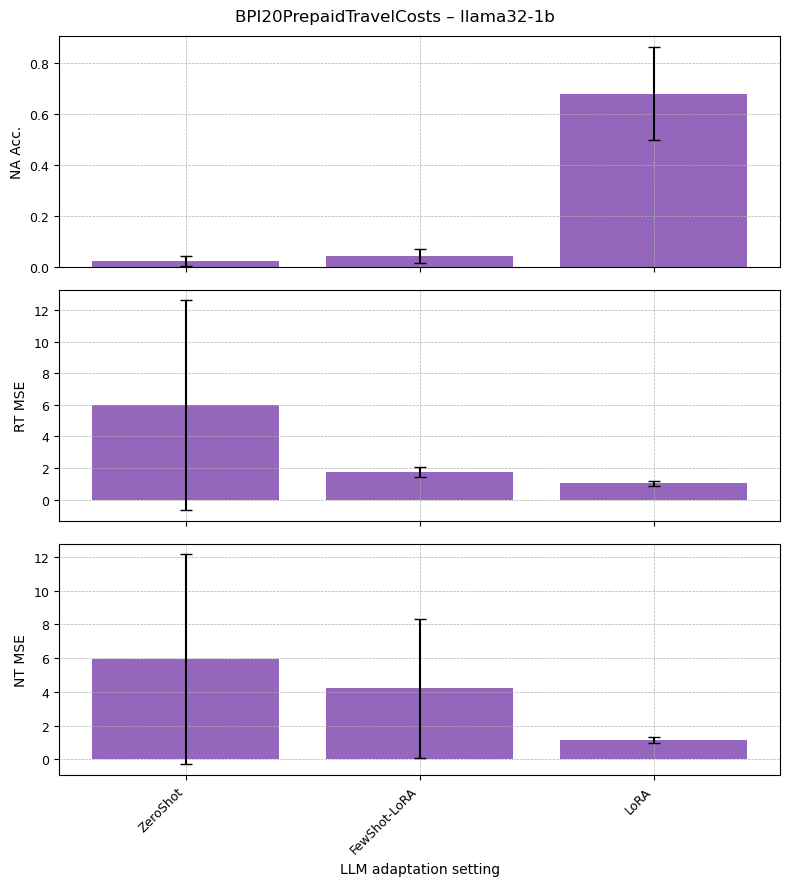

In [55]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

multi_path = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/multi_task_results_r256_a512.csv"
llm = pd.read_csv(multi_path)

if "Setting" not in llm.columns:
    raise ValueError("Column 'Setting' not found in multi_task_results_r256_a512.csv")

# keep only LLM backbones + selected settings
llm = llm[llm["backbone"].isin(LLM_BACKBONES)].copy()

KEEP_SETTINGS = ["ZeroShot", "LoRA", "FewShot-LoRA"]
llm = llm[llm["Setting"].isin(KEEP_SETTINGS)].copy()

llm["Setting_main"] = llm["Setting"]

plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"

SETTING_ORDER_FULL = [
    "ZeroShot",
    "FewShot-LoRA",
    "LoRA",
]

SETTING_ORDER_MAIN = [
    "ZeroShot",
    "FewShot-LoRA",
    "LoRA",
]

PLOTS = [
    ("test_next_activity_acc",            "NA Acc."),
    ("test_next_remaining_time_loss",     "RT MSE"),
    ("test_next_time_to_next_event_loss", "NT MSE"),
]

def _get_mean_std(df_one: pd.DataFrame, metric: str) -> tuple[float, float]:
    """
    Extract (mean, std) for a metric from an aggregated table row.
    Supports either:
      - columns: f"{metric}_mean", f"{metric}_std"
      - or column: f"{metric}_mean_std" formatted like "0.1234 ± 0.0056"
      - or (fallback) raw metric column (std=0)
    """
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    mean_std_col = f"{metric}_mean_std"

    if mean_col in df_one.columns:
        mean = float(df_one[mean_col].iloc[0])
        std = float(df_one[std_col].iloc[0]) if std_col in df_one.columns and pd.notna(df_one[std_col].iloc[0]) else 0.0
        return mean, std

    if mean_std_col in df_one.columns:
        s = str(df_one[mean_std_col].iloc[0])
        if "±" in s:
            left, right = s.split("±", 1)
            return float(left.strip()), float(right.strip())
        # if it's just a number string
        return float(s.strip()), 0.0

    if metric in df_one.columns:
        return float(df_one[metric].iloc[0]), 0.0

    raise KeyError(
        f"Could not find '{mean_col}'/'{std_col}' or '{mean_std_col}' (or '{metric}') in the aggregated CSV."
    )

for log_name, df_log in llm.groupby("log"):
    log_dir = os.path.join(plots_base_dir, log_name)
    os.makedirs(log_dir, exist_ok=True)

    for backbone, df_b in df_log.groupby("backbone"):

        settings_full = [s for s in SETTING_ORDER_FULL if s in df_b["Setting"].unique()]
        if not settings_full:
            continue

        fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

        x_labels = settings_full
        x = np.arange(len(x_labels))

        for ax, (metric, ylabel) in zip(axes, PLOTS):
            means = []
            stds = []

            for s in x_labels:
                row = df_b[df_b["Setting"] == s]
                if row.empty:
                    means.append(np.nan)
                    stds.append(0.0)
                else:
                    m, sd = _get_mean_std(row, metric)
                    means.append(m)
                    stds.append(sd)

            # drop missing entries (should rarely happen if your table is complete)
            keep = [i for i, v in enumerate(means) if pd.notna(v)]
            x_k = x[keep]
            means_k = [means[i] for i in keep]
            stds_k = [stds[i] for i in keep]
            labels_k = [x_labels[i] for i in keep]

            ax.bar(x_k, means_k, yerr=stds_k, capsize=4)
            ax.set_ylabel(ylabel)
            ax.set_xticks(x_k)
            ax.set_xticklabels(labels_k, rotation=45, ha="right")

        axes[-1].set_xlabel("LLM adaptation setting")
        fig.suptitle(f"{log_name} – {backbone}", fontsize=12)
        plt.tight_layout()

        out_path = os.path.join(log_dir, f"llm_methods_boxplot_selected_{log_name}_{backbone}.png")
        plt.savefig(out_path, dpi=300)
        plt.close(fig)

        print(f"Saved selected-methods boxplot for log={log_name}, backbone={backbone} to: {out_path}")

In [24]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

llm = df[df["backbone"].isin(LLM_BACKBONES)].copy()
llm["Setting"] = llm.apply(map_setting, axis=1)

# Keep only freezing variants
llm_freezing = llm[
    (llm["Setting"] == "Freezing") | (llm["Setting"].astype(str).str.startswith("Freezing-"))
].copy()
llm_freezing = llm_freezing[llm_freezing["Setting"] != "FewShot-Freezing"].copy()

plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"

# Order as in your example plot (will be filtered to what exists per run)
FREEZING_ORDER = [
    "Freezing",
    "Freezing-[-1]",
    "Freezing-[0]",
    "Freezing-[0, 1]",
    "Freezing-[-1, -2]",
]

PLOTS = [
    ("test_next_activity_acc",            "NA Acc."),
    ("test_next_remaining_time_loss",     "RT MSE"),
    ("test_next_time_to_next_event_loss", "NT MSE"),
]

for log_name, df_log in llm_freezing.groupby("log"):
    log_dir = os.path.join(plots_base_dir, log_name)
    os.makedirs(log_dir, exist_ok=True)

    for backbone, df_b in df_log.groupby("backbone"):
        # keep only the freezing settings that are present for this (log, backbone)
        settings = [s for s in FREEZING_ORDER if s in df_b["Setting"].unique()]
        # fallback: if something unexpected appears, include it (stable alphabetical after the known ones)
        extra = sorted([s for s in df_b["Setting"].unique() if s not in settings])
        settings = settings + extra

        if not settings:
            continue

        fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

        for ax, (metric, ylabel) in zip(axes, PLOTS):
            sns.boxplot(
                data=df_b,
                x="Setting",
                y=metric,
                order=settings,
                ax=ax,
            )
            ax.set_ylabel(ylabel)
            ax.set_xticks(range(len(settings)))
            ax.set_xticklabels(settings, rotation=45, ha="right")

        axes[-1].set_xlabel("Freezing configuration")

        fig.suptitle(f"{log_name} – {backbone} (Freezing variants)", fontsize=12)
        plt.tight_layout()

        out_path = os.path.join(
            log_dir,
            f"llm_methods_boxplot_freezing_{log_name}_{backbone}.png"
        )
        plt.savefig(out_path, dpi=300)
        plt.close(fig)

        print(f"Saved Freezing-only boxplot for log={log_name}, backbone={backbone} to: {out_path}")

Saved Freezing-only boxplot for log=BPI12, backbone=gemma-2-2b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_freezing_BPI12_gemma-2-2b.png
Saved Freezing-only boxplot for log=BPI12, backbone=gpt2 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_freezing_BPI12_gpt2.png
Saved Freezing-only boxplot for log=BPI12, backbone=gptneo-1b3 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_freezing_BPI12_gptneo-1b3.png
Saved Freezing-only boxplot for log=BPI12, backbone=llama32-1b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_freezing_BPI12_llama32-1b.png
Saved Freezing-only boxplot for log=BPI12, backbone=qwen25-05b to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/llm_methods_boxplot_freezing_BPI12_qwen25-05b.png
Saved Freezing-only boxplot for log=BPI17, backbone=

In [25]:
def fetch_single(
    wandb_id: str,
    targets=["na", "rt", "nt"],
    project_name: str | None = None,
    entity: str | None = None,
):
    """
    Holt Verlaufskurven (pro Epoch) für einen einzelnen W&B-Run.
    Gibt (na_acc, na_loss, rt_loss, nt_loss) als Listen zurück.
    Fehlende Targets -> entsprechende Liste = None.
    """
    if isinstance(targets, str):
        targets = [targets]

    if project_name is None:
        raise ValueError("fetch_single requires an explicit project_name.")

    if entity is None:
        entity = os.environ.get("ENTITY")
        if entity is None:
            raise ValueError("ENTITY not set and no entity passed to fetch_single().")

    api = wandb.Api()
    run = api.run(f"{entity}/{project_name}/{wandb_id}")
    history = list(run.scan_history())

    na_acc, na_loss, rt_loss, nt_loss = None, None, None, None

    if "rt" in targets:
        rt_loss = [
            row["test_next_remaining_time_loss"]
            for row in history
            if "test_next_remaining_time_loss" in row
        ]

    if "na" in targets:
        na_loss = [
            row["test_next_activity_loss"]
            for row in history
            if "test_next_activity_loss" in row
        ]
        na_acc = [
            row["test_next_activity_acc"]
            for row in history
            if "test_next_activity_acc" in row
        ]

    if "nt" in targets:
        nt_loss = [
            row["test_next_time_to_next_event_loss"]
            for row in history
            if "test_next_time_to_next_event_loss" in row
        ]

    return na_acc, na_loss, rt_loss, nt_loss


# Pfad für Loss-Curves-CSV
loss_csv_path = os.path.join(output_dir_csv, "loss_curves_multitask_lora_best.csv")

LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]

if os.path.exists(loss_csv_path):
    losses = pd.read_csv(loss_csv_path)
else:
    # Nur LLM + LoRA
    df_lora = df[
        df["backbone"].isin(LLM_BACKBONES)
        & (df["fine_tuning"] == "lora")
    ].copy()

    # Nur "Full-LoRA" (keine Few-Shot-LoRA)
    if "few_shot_k" in df_lora.columns:
        df_lora = df_lora[df_lora["few_shot_k"].isna()].copy()

    # Score-Spalte für beste Runs
    score_col = "mt_score"
    if score_col not in df_lora.columns:
        score_col = "test_next_activity_acc"

    # Bester LoRA-Run pro (log, backbone)
    best_runs = (
        df_lora
        .sort_values(score_col, ascending=False)
        .groupby(["log", "backbone"], as_index=False)
        .head(1)
    )

    losses_list = []

    for _, row in best_runs.iterrows():
        na_acc, na_loss, rt_loss, nt_loss = fetch_single(
            wandb_id=row["id"],
            project_name=row["project"],
            entity=entity,
            targets=["na", "rt", "nt"],
        )

        # falls etwas fehlt → überspringen
        if na_loss is None or rt_loss is None or nt_loss is None:
            continue

        tmp = pd.DataFrame({
            "epoch": range(len(na_loss)),
            "na_acc": na_acc,
            "na_loss": na_loss,
            "rt_loss": rt_loss,
            "nt_loss": nt_loss,
        })
        tmp["log"] = row["log"]
        tmp["backbone"] = row["backbone"]
        losses_list.append(tmp)

    if not losses_list:
        raise RuntimeError("Keine Loss-Curves für LoRA-Runs gefunden.")

    losses = pd.concat(losses_list, axis=0, ignore_index=True)
    losses.to_csv(loss_csv_path, index=False)
    print("Saved LoRA loss curves to:", loss_csv_path)

print("Loss curves shape (LoRA best runs):", losses.shape)

Loss curves shape (LoRA best runs): (250, 7)


In [26]:
LOGS_TO_PLOT = sorted(losses["log"].unique())

HUE_MAP = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}

HUE_ORDER = [
    "GPT2",
    "GPT-Neo-1.3B",
    "Qwen2.5-0.5B",
    "Llama3.2-1B",
    "Gemma-2-2B",
]

# Long-Format
l = losses.melt(
    id_vars=["log", "backbone", "epoch"],
    value_vars=["na_loss", "rt_loss", "nt_loss"],
    var_name="Loss",
    value_name="Value",
).dropna(subset=["Value"])

l["Backbone"] = l["backbone"].map(HUE_MAP)
l = l[l["Backbone"].notna()]

LOSS_LABELS = {
    "na_loss": "NA Loss",
    "rt_loss": "RT Loss",
    "nt_loss": "NT Loss",
}

fig, axes = plt.subplots(
    3, len(LOGS_TO_PLOT),
    figsize=(4 * len(LOGS_TO_PLOT), 8),
    sharex=True
)
axes_iter = iter(axes.flatten())

legend_handles, legend_labels = None, None  # globale Legende

for loss_name in ["na_loss", "rt_loss", "nt_loss"]:
    for log_name in LOGS_TO_PLOT:
        ax = next(axes_iter)
        tmp = l[(l["Loss"] == loss_name) & (l["log"] == log_name)]

        sns.lineplot(
            data=tmp,
            x="epoch",
            y="Value",
            hue="Backbone",
            hue_order=[h for h in HUE_ORDER if h in tmp["Backbone"].unique()],
            ax=ax,
            linewidth=2.0,
        )

        ax.set_xlabel("Epoch")
        ax.set_ylabel(LOSS_LABELS[loss_name])
        ax.set_title(log_name)

        # Legend nur einmal abgreifen
        leg = ax.get_legend()
        if leg is not None:
            handles, labels = leg.legend_handles, [t.get_text() for t in leg.get_texts()]
            legend_handles, legend_labels = handles, labels
            leg.remove()

# globale Legende unter der Figure
if legend_handles is not None:
    fig.legend(
        legend_handles,
        legend_labels,
        title="",
        loc="lower center",
        ncol=len(legend_labels),
        bbox_to_anchor=(0.5, -0.02),
    )

plt.tight_layout(rect=(0, 0.05, 1, 1))  # unten Platz für Legende lassen

plot_path = os.path.join(output_dir_plots, "loss_curves_multitask_lora_best.png")
plt.savefig(plot_path, dpi=300)
plt.close(fig)

print("Saved LoRA loss curve plot to:", plot_path)

Saved LoRA loss curve plot to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/loss_curves_multitask_lora_best.png


In [27]:
# PARAMETER-SUMMARY 

multi_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi = pd.read_csv(multi_path)

# Nur Zeilen mit Parameterinfos
param_summary = (
    multi[
        [
            "log",
            "backbone",
            "Setting",
            "total_params",
            "trainable_params",
        ]
    ]
    .dropna(subset=["total_params", "trainable_params"])
    .drop_duplicates()
    .copy()
)

# Anteil trainierbarer Parameter in %
param_summary["trainable_percent"] = (
    param_summary["trainable_params"] / param_summary["total_params"] * 100.0
)

param_summary["trainable_percent_fmt"] = (
    param_summary["trainable_percent"].round(1).astype(str) + "%"
)

# total_params schön formatiert (wissenschaftliche Notation)
param_summary["total_params_fmt"] = param_summary["total_params"].apply(
    lambda x: np.format_float_scientific(x, precision=1)
)

param_summary["# params\n(%trainable)"] = (
    param_summary["total_params_fmt"]
    + " ("
    + param_summary["trainable_percent_fmt"]
    + ")"
)

# falls vorhanden, Dataset & hübsche Namen mitnehmen
if "Dataset" in multi.columns:
    param_summary["Dataset"] = multi.set_index(
        ["log", "backbone", "Setting"]
    ).loc[
        param_summary.set_index(["log", "backbone", "Setting"]).index,
        "Dataset"
    ].values
else:
    param_summary["Dataset"] = param_summary["log"]

if "Backbone_pretty" in multi.columns:
    param_summary["Backbone_pretty"] = multi.set_index(
        ["log", "backbone", "Setting"]
    ).loc[
        param_summary.set_index(["log", "backbone", "Setting"]).index,
        "Backbone_pretty"
    ].values
else:
    param_summary["Backbone_pretty"] = param_summary["backbone"]

# --- pro Datensatz (log) speichern ---
for log_name, df_log in param_summary.groupby("log"):
    log_dir = os.path.join(output_dir_csv, "per_dataset", log_name)
    os.makedirs(log_dir, exist_ok=True)

    csv_path = os.path.join(log_dir, "param_summary_multitask.csv")
    df_log.to_csv(csv_path, index=False)
    print(f"Saved param summary for {log_name} to: {csv_path}")

Saved param summary for BPI12 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI12/param_summary_multitask.csv
Saved param summary for BPI17 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI17/param_summary_multitask.csv
Saved param summary for BPI20PrepaidTravelCosts to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20PrepaidTravelCosts/param_summary_multitask.csv
Saved param summary for BPI20RequestForPayment to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20RequestForPayment/param_summary_multitask.csv
Saved param summary for BPI20TravelPermitData to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/csv/per_dataset/BPI20TravelPermitData/param_summary_multitask.csv


In [28]:
# === PARETO: MT-Score vs. trainierbare Parameter (LoRA, best per LLM-Backbone) ===

multi_path = os.path.join(output_dir_csv, "multi_task_benchmark_results.csv")
multi = pd.read_csv(multi_path)

# Relevante LLM-Backbones + Pretty Names
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
BACKBONE_MAP_LLM = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}

# Nur LLM + LoRA + benötigte Spalten
pareto_source = multi[
    (multi["backbone"].isin(LLM_BACKBONES))
    & (multi["Setting"] == "LoRA")
    & multi["trainable_params"].notna()
    & multi["mt_score_mean"].notna()
].copy()

# Pretty-Namen ergänzen (falls noch nicht vorhanden)
if "Backbone_pretty" not in pareto_source.columns:
    pareto_source["Backbone_pretty"] = (
        pareto_source["backbone"]
        .map(BACKBONE_MAP_LLM)
        .fillna(pareto_source["backbone"])
    )

plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"

for log_name, df_log in pareto_source.groupby("log"):
    # pro Datensatz: bester LoRA-Run je Backbone
    df_best = (
        df_log
        .sort_values(
            ["backbone", "mt_score_mean", "trainable_params"],
            ascending=[True, False, True],  # Score ↓, bei Tie weniger Params ↑
        )
        .drop_duplicates(subset=["backbone"], keep="first")
        .reset_index(drop=True)
    )

    if df_best.empty:
        continue

    # etwas breiter, damit die Legend unten gut passt
    fig, ax = plt.subplots(figsize=(9, 4.5))

    # Scatter: ein Punkt pro Backbone
    for bb, df_b in df_best.groupby("backbone"):
        label = df_b["Backbone_pretty"].iloc[0]
        ax.scatter(
            df_b["trainable_params"],
            df_b["mt_score_mean"],
            label=label,
            s=70,
        )

    # Pareto-Front hervorheben (min trainable_params, max mt_score_mean)
    df_pf = df_best.sort_values("trainable_params")
    best_so_far = -np.inf
    pareto_mask = []
    for _, row in df_pf.iterrows():
        if row["mt_score_mean"] >= best_so_far - 1e-9:
            pareto_mask.append(True)
            best_so_far = row["mt_score_mean"]
        else:
            pareto_mask.append(False)
    df_pf_pareto = df_pf[pareto_mask]

    if not df_pf_pareto.empty:
        ax.scatter(
            df_pf_pareto["trainable_params"],
            df_pf_pareto["mt_score_mean"],
            s=140,
            facecolors="none",
            edgecolors="black",
            linewidths=1.5,
        )

    ax.set_xscale("log")
    ax.set_xlabel("Trainable parameters (LoRA, log scale)")
    ax.set_ylabel("MT-Score (mean across seeds)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Titel: wenn Dataset-Spalte existiert, nimm diese Bezeichnung
    if "Dataset" in df_best.columns:
        ds_label = df_best["Dataset"].iloc[0]
    else:
        ds_label = log_name
    ax.set_title(f"{ds_label} – LLM LoRA Pareto (best per backbone)")

    # Legend unten über die ganze Breite
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Backbone",
        loc="lower center",
        ncol=len(labels),
        frameon=False,
        bbox_to_anchor=(0.5, -0.02),
    )

    # Platz für die Legend unten lassen
    plt.tight_layout(rect=(0, 0.12, 1, 1))

    log_dir = os.path.join(plots_base_dir, log_name)
    os.makedirs(log_dir, exist_ok=True)
    out_path = os.path.join(log_dir, f"pareto_llm_lora_{log_name}.png")

    plt.savefig(out_path, dpi=300)
    plt.close(fig)

    print(f"Saved Pareto plot for log={log_name} to: {out_path}")

Saved Pareto plot for log=BPI12 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/pareto_llm_lora_BPI12.png
Saved Pareto plot for log=BPI17 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI17/pareto_llm_lora_BPI17.png
Saved Pareto plot for log=BPI20PrepaidTravelCosts to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20PrepaidTravelCosts/pareto_llm_lora_BPI20PrepaidTravelCosts.png
Saved Pareto plot for log=BPI20RequestForPayment to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20RequestForPayment/pareto_llm_lora_BPI20RequestForPayment.png
Saved Pareto plot for log=BPI20TravelPermitData to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20TravelPermitData/pareto_llm_lora_BPI20TravelPermitData.png


In [29]:
LLM_BACKBONES = ["gpt2", "gptneo-1b3", "qwen25-05b", "llama32-1b", "gemma-2-2b"]
BACKBONE_MAP_LLM = {
    "gpt2":         "GPT2",
    "gptneo-1b3":   "GPT-Neo-1.3B",
    "qwen25-05b":   "Qwen2.5-0.5B",
    "llama32-1b":   "Llama3.2-1B",
    "gemma-2-2b":   "Gemma-2-2B",
}

# Datensatz-Kürzel (wie bisher)
DATASET_MAP = {
    "BPI12": "BPI12",
    "BPI17": "BPI17",
    "BPI20PrepaidTravelCosts": "BPI20PTC",
    "BPI20RequestForPayment": "BPI20RfP",
    "BPI20TravelPermitData": "BPI20TPD",
}

# 1) Alle LLM-LoRA-Runs aus den Roh-Runs df ziehen
lora_all = df[
    df["backbone"].isin(LLM_BACKBONES)
    & (df["fine_tuning"] == "lora")
].copy()

# Voll-LoRA (ohne Few-Shot-LoRA)
if "few_shot_k" in lora_all.columns:
    lora_all = lora_all[lora_all["few_shot_k"].isna()].copy()

# nur Zeilen mit Parametern & MT-Score
if "mt_score" not in lora_all.columns:
    raise ValueError("Spalte 'mt_score' fehlt in df – bitte sicherstellen, dass sie vorher berechnet wird.")

lora_all = lora_all[
    lora_all["trainable_params"].notna()
    & lora_all["mt_score"].notna()
].copy()

if lora_all.empty:
    print("Keine LoRA-Sweeps mit trainable_params + mt_score gefunden – Pareto-Front wird übersprungen.")
else:
    # 2) HParam-Kombi definieren (deine Sweep-Parameter)
    HP_SWEEP_COLS = [
        "lr",
        "batch_size",
        "epochs",
        "r",
        "lora_alpha",
        "embedding_size",
        "hidden_size",
        "strategy",
    ]
    HP_SWEEP_COLS = [c for c in HP_SWEEP_COLS if c in lora_all.columns]

    group_cols_sweep = ["log", "backbone"] + HP_SWEEP_COLS

    # 3) Über Seeds mitteln: MT-Score + trainable_params
    lora_sweeps_grouped = (
        lora_all
        .groupby(group_cols_sweep, dropna=False)
        .agg(
            mt_score_mean=("mt_score", "mean"),
            mt_score_std=("mt_score", "std"),
            trainable_params=("trainable_params", "mean"),
        )
        .reset_index()
    )

    # Backbone-Label
    lora_sweeps_grouped["Backbone_pretty"] = (
        lora_sweeps_grouped["backbone"]
        .map(BACKBONE_MAP_LLM)
        .fillna(lora_sweeps_grouped["backbone"])
    )

    plots_base_dir = "/ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset"

    # 4) Pro Datensatz: All-Sweeps + echte Pareto-Front
    for log_name, df_log in lora_sweeps_grouped.groupby("log"):
        if df_log.empty:
            continue

        fig, ax = plt.subplots(figsize=(10, 5))

        # --- alle Sweeps: Linien je Backbone (wie zuvor) ---
        for bb, df_b in df_log.groupby("backbone"):
            df_b = df_b.sort_values("trainable_params")
            label = df_b["Backbone_pretty"].iloc[0]

            ax.plot(
                df_b["trainable_params"],
                df_b["mt_score_mean"],
                marker="o",
                linestyle="-",
                linewidth=1.0,
                markersize=6,
                label=label,
                alpha=0.9,
            )

        # --- echte Pareto-Front über ALLE Sweeps dieses Datensatzes ---
        # Ziele: min trainable_params, max mt_score_mean
        df_sorted = df_log.sort_values("trainable_params")
        best_score = -np.inf
        pareto_rows = []

        for _, row in df_sorted.iterrows():
            score = row["mt_score_mean"]
            if score >= best_score - 1e-9:
                pareto_rows.append(row)
                best_score = score

        pareto_df = pd.DataFrame(pareto_rows)

        if not pareto_df.empty:
            pareto_df = pareto_df.sort_values("trainable_params")
            ax.plot(
                pareto_df["trainable_params"],
                pareto_df["mt_score_mean"],
                color="black",
                linewidth=1.3,
                marker="o",
                markersize=4,
                label="Pareto front",
            )

        ax.set_xscale("log")
        ax.set_xlabel("Trainable parameters (LoRA, log scale)")
        ax.set_ylabel("MT-Score (mean across seeds)")

        ds_label = DATASET_MAP.get(log_name, log_name)
        ax.set_title(f"{ds_label} – LLM LoRA sweeps (Pareto front)")

        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Legend unten zentriert wie beim anderen Plot
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            title="Backbone / front",
            loc="lower center",
            ncol=len(labels),
            bbox_to_anchor=(0.5, -0.02),
        )

        # Platz für Legende lassen
        plt.tight_layout(rect=(0, 0.10, 1, 1))

        log_dir = os.path.join(plots_base_dir, log_name)
        os.makedirs(log_dir, exist_ok=True)
        out_path = os.path.join(log_dir, f"pareto_llm_lora_sweeps_true_{log_name}.png")

        plt.savefig(out_path, dpi=300)
        plt.close(fig)

        print(f"Saved TRUE Pareto-front LoRA-sweeps plot for log={log_name} to: {out_path}")


Saved TRUE Pareto-front LoRA-sweeps plot for log=BPI12 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI12/pareto_llm_lora_sweeps_true_BPI12.png
Saved TRUE Pareto-front LoRA-sweeps plot for log=BPI17 to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI17/pareto_llm_lora_sweeps_true_BPI17.png
Saved TRUE Pareto-front LoRA-sweeps plot for log=BPI20PrepaidTravelCosts to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20PrepaidTravelCosts/pareto_llm_lora_sweeps_true_BPI20PrepaidTravelCosts.png
Saved TRUE Pareto-front LoRA-sweeps plot for log=BPI20RequestForPayment to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20RequestForPayment/pareto_llm_lora_sweeps_true_BPI20RequestForPayment.png
Saved TRUE Pareto-front LoRA-sweeps plot for log=BPI20TravelPermitData to: /ceph/lfertig/Thesis/notebook/llm-peft-ppm/results/plots/per_dataset/BPI20TravelPermitData/pareto_llm_lora_sweeps_true_BPI20TravelPe